In [13]:
# external imports
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# internal imports
os.chdir("../")
import src.utils.qe_helper as qe_helper
os.chdir("./analysis")

# setup for plots
plt.rcParams["text.usetex"] = True
plt.rc("font", family="serif")
plt.rc("xtick", labelsize="x-small")
plt.rc("ytick", labelsize="x-small")
plt.rc("text", usetex=True)

In [14]:
"""
Function to parse all the data from a single material.
The data is stored in a .csv file and the structure in a pickle file.
"""


def get_calc_data(calc_id, binding_energies):
    # dummy values (useful for to check whether a calculation is still running)
    omega_irr = -100
    distance_mean = -100
    direct_gap = -100
    indirect_gap = -100
    eff_mass = -100
    hole_mass = -100
    elec_mass = -100
    vbm_deriv = -100
    ionic_eps = -100
    elec_eps = -100
    nv_unnorm = -100
    nv = -100
    nc_unnorm = -100
    nc = -100
    nv_dict = {}
    nc_dict = {}

    # energy range for numerically degenerate bands
    degen_factor = 0.01

    # parse the structure file for the bond length
    f = open(f"../calc/{calc_id}/structure.pckl", "rb")
    structure, structure_name = pickle.load(f)
    f.close()

    # check whether this is a binary compound with 2 atoms in the unit cell
    # this is needed for the Dvorak et al. plot
    binary = False
    elems, counts = np.unique(structure.species, return_counts=True)
    if len(np.unique(elems)) == 2 and len(np.unique(counts)) == 1:
        binary = True

    # before calculating the bond length, we need to standardize the cell
    # to obtain the characteristic lengths of the unit cell to normalize the derivatives
    structure = qe_helper.qe_standardize_cell(structure, symprec=0.1)
    try:
        _, structure = qe_helper.qe_get_ibrav(structure)
    except:
        print(f"Using standardize_cell for {calc_id}")
        structure = qe_helper.qe_standardize_cell(structure, symprec=0.1)
    boxlengths = np.max(np.abs(structure.lattice.matrix), axis=0)

    # create a supercell to estimated the average minimal bond length more easily
    structure.make_supercell([2, 2, 2])  # in-place operation

    # estimate the bond length by getting the minimal distance between
    # atoms i and j (i!=j) and than average over all unique distance
    # that dont differ by more than 1e-3 angstroms
    dist1 = []
    for i in range(structure.num_sites):
        dist2 = []
        for j in range(structure.num_sites):
            if i != j:
                dist2.append(structure.get_distance(i, j))
        dist1.append(np.min(np.unique(np.round(dist2, 3))))
    bond_length = np.round(np.mean(dist1), 2)

    # find out where the results are stored
    calc_id_path = f"../calc/{calc_id}"
    csv_paths = []  # path to calculation results
    for dirpath, __, filenames in os.walk(calc_id_path):
        for filename in filenames:
            if ".csv" in filename:
                csv_paths.append(os.path.join(dirpath, filename))

    # parse all results
    for csv_name in csv_paths:
        # wannier spread
        if "omega_irr" in csv_name:
            omega_df = pd.read_csv(csv_name, header=None)
            omega_irr = omega_df[0][0]

        # wannier mean distance
        if "mlwf_distance_mean" in csv_name:
            distance_df = pd.read_csv(csv_name, header=None)
            distance_mean = distance_df[0][0] / bond_length

        # direct bandgap
        if "direct_gap" in csv_name and not "indirect_gap" in csv_name:
            direct_df = pd.read_csv(csv_name, header=None)
            direct_gap = direct_df[0][0]

        # indirect bandgap
        if "indirect_gap" in csv_name:
            indirect_df = pd.read_csv(csv_name, header=None)
            indirect_gap = indirect_df[0][0]

        # ionic part of the static dielectric function (VASP)
        if "eps_ionic" in csv_name:
            static_df = pd.read_csv(csv_name, header=None, sep=" ")
            ionic_eps = (static_df[0][0] + static_df[1][1] + static_df[2][2]) / 3

        # electronic part of the static dielectric function (VASP)
        if "eps_static" in csv_name:
            static_df = pd.read_csv(csv_name, header=None, sep=" ")
            elec_eps = (static_df[0][0] + static_df[1][1] + static_df[2][2]) / 3

        # effective masses
        if "hole_mass" in csv_name:
            emasses_df = pd.read_csv(
                csv_name,
                skiprows=1,
                header=None,
                sep=" ",
                names=["occ", "mx", "my", "mz", "En"],
            )
            num_bands = len(emasses_df)
            vbm_energy = emasses_df.iloc[int(num_bands / 2) - 1]["En"]
            vbm_bands = emasses_df[(emasses_df["En"] < (vbm_energy + degen_factor))]
            vbm_bands = vbm_bands[(vbm_bands["En"] > (vbm_energy - degen_factor))]
            vbm_bands = vbm_bands.drop(["En", "occ"], axis=1)
            vbm_bands_flat = np.hstack(vbm_bands.iloc[:].values)
            hole_mass = 1 / np.mean(abs(1 / vbm_bands_flat))

        if "elec_mass" in csv_name:
            emasses_df = pd.read_csv(
                csv_name,
                skiprows=1,
                header=None,
                sep=" ",
                names=["occ", "mx", "my", "mz", "En"],
            )
            num_bands = len(emasses_df)
            cbm_energy = emasses_df.iloc[int(num_bands / 2)]["En"]
            cbm_bands = emasses_df[(emasses_df["En"] < (cbm_energy + degen_factor))]
            cbm_bands = cbm_bands[(cbm_bands["En"] > (cbm_energy - degen_factor))]
            cbm_bands = cbm_bands.drop(["En", "occ"], axis=1)
            cbm_bands_flat = np.hstack(cbm_bands.iloc[:].values)
            elec_mass = 1 / np.mean(abs(1 / cbm_bands_flat))

        # minimum of band derivatives (only VB)
        if "mean_VB_derivatives" in csv_name:
            band_derivs_df = pd.read_csv(
                csv_name, header=None, sep=" ", names=["Ex", "Ey", "Ez"]
            )
            vbm_derivs = band_derivs_df.iloc[0].values
            vbm_derivs = vbm_derivs * boxlengths
            vbm_deriv = np.mean([vbm_derivs[0], vbm_derivs[1], vbm_derivs[2]])

        # minimum of band derivatives (only VB, L2)
        if "_L2_" in csv_name:
            band_derivs_df = pd.read_csv(
                csv_name, header=None, sep=" ", names=["L2_mean"]
            )
            vbm_derivs_L2 = band_derivs_df.iloc[0].values[0]
            # vbm_derivs = vbm_derivs * boxlengths

        # local DOS
        if "ldos.csv" in csv_name:
            # parse the data
            ldos_df = pd.read_csv(
                csv_name, header=None, names=["Name", "Nv", "Nc"], delim_whitespace=True
            )

            # first sum up the valence states to find the anion
            sum_dos = []
            for name in np.unique(ldos_df["Name"]):
                sum_dos.append(np.sum(ldos_df.loc[ldos_df["Name"] == name]["Nv"]))
            anion_idx = np.argmax(sum_dos)
            nv_unnorm = sum_dos[anion_idx]
            nv = nv_unnorm / np.sum(sum_dos)

            # then sum up the wanted states
            sum_dos = []
            for name in np.unique(ldos_df["Name"]):
                sum_dos.append(np.sum(ldos_df.loc[ldos_df["Name"] == name]["Nc"]))
            nc_unnorm = sum_dos[anion_idx]
            nc = nc_unnorm / np.sum(sum_dos)

        # local DOS_ranges
        if "ldos_E" in csv_name:
            # parse the data
            ldos_df = pd.read_csv(
                csv_name, header=None, names=["Name", "Nv", "Nc"], delim_whitespace=True
            )

            # first sum up the valence states to find the anion
            sum_dos = []
            for name in np.unique(ldos_df["Name"]):
                sum_dos.append(np.sum(ldos_df.loc[ldos_df["Name"] == name]["Nv"]))
            anion_idx = np.argmax(sum_dos)
            nv_unnorm_curr = sum_dos[anion_idx]
            nv_curr = nv_unnorm_curr / np.sum(sum_dos)
            nv_dict[csv_name[-9:-4]] = nv_curr

            # then sum up the wanted states
            sum_dos = []
            for name in np.unique(ldos_df["Name"]):
                sum_dos.append(np.sum(ldos_df.loc[ldos_df["Name"] == name]["Nc"]))
            nc_unnorm_curr = sum_dos[anion_idx]
            nc_curr = nc_unnorm_curr / np.sum(sum_dos)
            nc_dict[csv_name[-9:-4]] = nc_curr

    # calculate the effective mass
    if hole_mass != -100 and elec_mass != -100:
        eff_mass = abs(elec_mass * hole_mass / (abs(hole_mass) + abs(elec_mass)))

    # get the corresponding binding energy from the dataset
    binding_energy = binding_energies["binding_energy"][calc_id]
    binding_energy_std = binding_energies["binding_energy_std"][calc_id]

    # output arrays split into numeric and string types
    meta_data = [calc_id, structure_name]
    num_data = [
        bond_length,
        binding_energy,
        binding_energy_std,
        direct_gap,
        indirect_gap,
        hole_mass,
        elec_mass,
        eff_mass,
        elec_eps,
        ionic_eps,
        omega_irr,
        distance_mean,
        vbm_deriv,
        nv_unnorm,
        nv,
        nc_unnorm,
        nc,
        binary,
        vbm_derivs_L2,
        nv_dict,
        nc_dict,
    ]

    return meta_data, num_data

In [15]:
"""
Data parsing and formatting the exciton binding energy dataset. 
We pack everything into a pandas dataframe for easier handling.    
"""

# parse the experimental binding energies
binding_energies = pd.read_csv(
    os.path.join("..", "expdata", "exp_exciton_binding.csv"),
    header=None,
    names=["id", "binding_energy", "binding_energy_std", "name"],
)
binding_energies = binding_energies.set_index(["id"])

# initialize lists
meta_data = []
num_data = []

# create the data array
calc_ids = os.listdir("../calc/")
for calc_id in calc_ids:
    try:
        temp_meta, temp_num = get_calc_data(calc_id, binding_energies)
    except:
        print(f"Error in {calc_id}")
        continue
    meta_data.append(temp_meta)
    num_data.append(temp_num)
meta_data = np.array(meta_data)
num_data = np.array(num_data)

# we sort by the ids
id_nums = []
for r in meta_data:
    id_nums.append(int(r[0].split("-")[1]))
meta_data = meta_data[np.argsort(id_nums)]
num_data = num_data[np.argsort(id_nums)]

# variable names
var_names = [
    "bond_length",
    "binding_energy",
    "binding_energy_std",
    "direct_gap",
    "indirect_gap",
    "hole_mass",
    "elec_mass",
    "eff_mass",
    "elec_eps",
    "ionic_eps",
    "omega_irr",
    "distance_mean",
    "vbm_deriv",
    "nv_unnorm",
    "nv",
    "nc_unnorm",
    "nc",
    "binary",
    "vbm_deriv_L2",
    "nv_dict",
    "nc_dict",
]

# convert the data to a dataframe
result_df = pd.DataFrame(meta_data[:, 1:], columns=["name"], index=meta_data[:, 0])

# append the rest
for i, v in enumerate(var_names):
    result_df[v] = num_data[:, i]

# add WM prediction
ry_const = 13.605693  # eV
result_df["WM_elec"] = (
    1000 * ry_const * result_df["eff_mass"] / (result_df["elec_eps"]) ** 2
)
result_df["WM_total"] = (
    1000
    * ry_const
    * result_df["eff_mass"]
    / (result_df["elec_eps"] + result_df["ionic_eps"]) ** 2
)

# add NvNc
result_df["nvnc"] = result_df["nv"] * result_df["nc"]
result_df["nvnc_unnorm"] = result_df["nv_unnorm"] * result_df["nc_unnorm"]

result_df["binding_energy"] = result_df["binding_energy"].astype(float)

Error in mp-1087
Error in mp-111
Error in mp-1138


c:\Users\grune\anaconda3\envs\ml\Lib\site-packages\pymatgen\core\periodic_table.py:219: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


Error in mp-1143
Error in mp-1228891
Error in mp-1253
Error in mp-1265
Error in mp-1342
Error in mp-1415
Error in mp-149
Error in mp-1500
Error in mp-1550
Error in mp-1672
Error in mp-1784
Error in mp-1985
Error in mp-20351
Error in mp-2064
Error in mp-2160
Error in mp-22862
Error in mp-22870
Error in mp-22875
Error in mp-22898
Error in mp-22903
Error in mp-22916
Error in mp-23037
Error in mp-23155
Error in mp-23167
Error in mp-23193


c:\Users\grune\anaconda3\envs\ml\Lib\site-packages\pymatgen\core\periodic_table.py:219: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


Error in mp-23202
Error in mp-23251
Error in mp-23268
Error in mp-23291
Error in mp-23703
Error in mp-2472
Error in mp-2490
Error in mp-2534
Error in mp-2605
Error in mp-2758
Error in mp-28077
Error in mp-463
Error in mp-611517
Error in mp-612118
Error in mp-66
Error in mp-661
Error in mp-682
Error in mp-732337
Error in mp-804
Error in mp-8062
Error in mp-856
Using standardize_cell for mp-909
Error in mp-909
Error in mp-995214


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# classifications to make the plots more readable
rare_gases = ["mp-111", "mp-23155", "mp-612118", "mp-611517"] # Ne, Ar, Kr, Xe
four       = ["mp-66", "mp-149", "mp-1985", "mp-8062"] # C, Si, C3N4, beta-SiC
three_five = ["mp-661", "mp-804", "mp-1550", "mp-2490", "mp-2534", "mp-20351", "mp-1228891"] # AlN, GaN, AlP, GaP, GaAs, InP, AlGaAs2
two_six    = ["mp-1087", "mp-1253", "mp-1265", "mp-1342", "mp-1415", "mp-1500", "mp-1672", "mp-2472", "mp-2605", "mp-2758"] # SrS, BaSe, MgO, BaO, CaSe, BaS, CaS, SrO, CaO, SrSe
one_seven  = ["mp-463", "mp-682", "mp-1138", "mp-1784",  "mp-2064", "mp-22862", "mp-22898", # KF, NaF, LiF, CsF, RbF, NaCl, KI,
              "mp-22903", "mp-22916", "mp-23193", "mp-23251", "mp-23268", "mp-23703"] # RbI, NaBr, KCl, KBr, NaI, LiH
others     = ["mp-856", "mp-909", "mp-1143", "mp-2160", "mp-22870", "mp-22875", "mp-23037", # SnO2, As2Se3, alpha-Al2O3, Sb2Se3, InBr, TlBr, CsPbCl3,
              "mp-23167", "mp-23202", "mp-23291", "mp-28077", "mp-732337", "mp-995214"	] #  TlCl, InI, PbCl2, PbBr2, MaPbBr3, MaPbI3
all_mats = [four, three_five, two_six, one_seven, rare_gases, others]
all_markers = ["v", "x", "o",  "D", "s", "P"]
all_colors = ["tab:red", "tab:green", "tab:orange", "tab:blue", "k", "silver"]
all_labels = [r"IV", r"III-V", r"II-VI", r"I-VII", r"VIII", r"Others"]
marker_size = 10

C:\Users\grune\AppData\Local\Temp\ipykernel_15564\1176854004.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


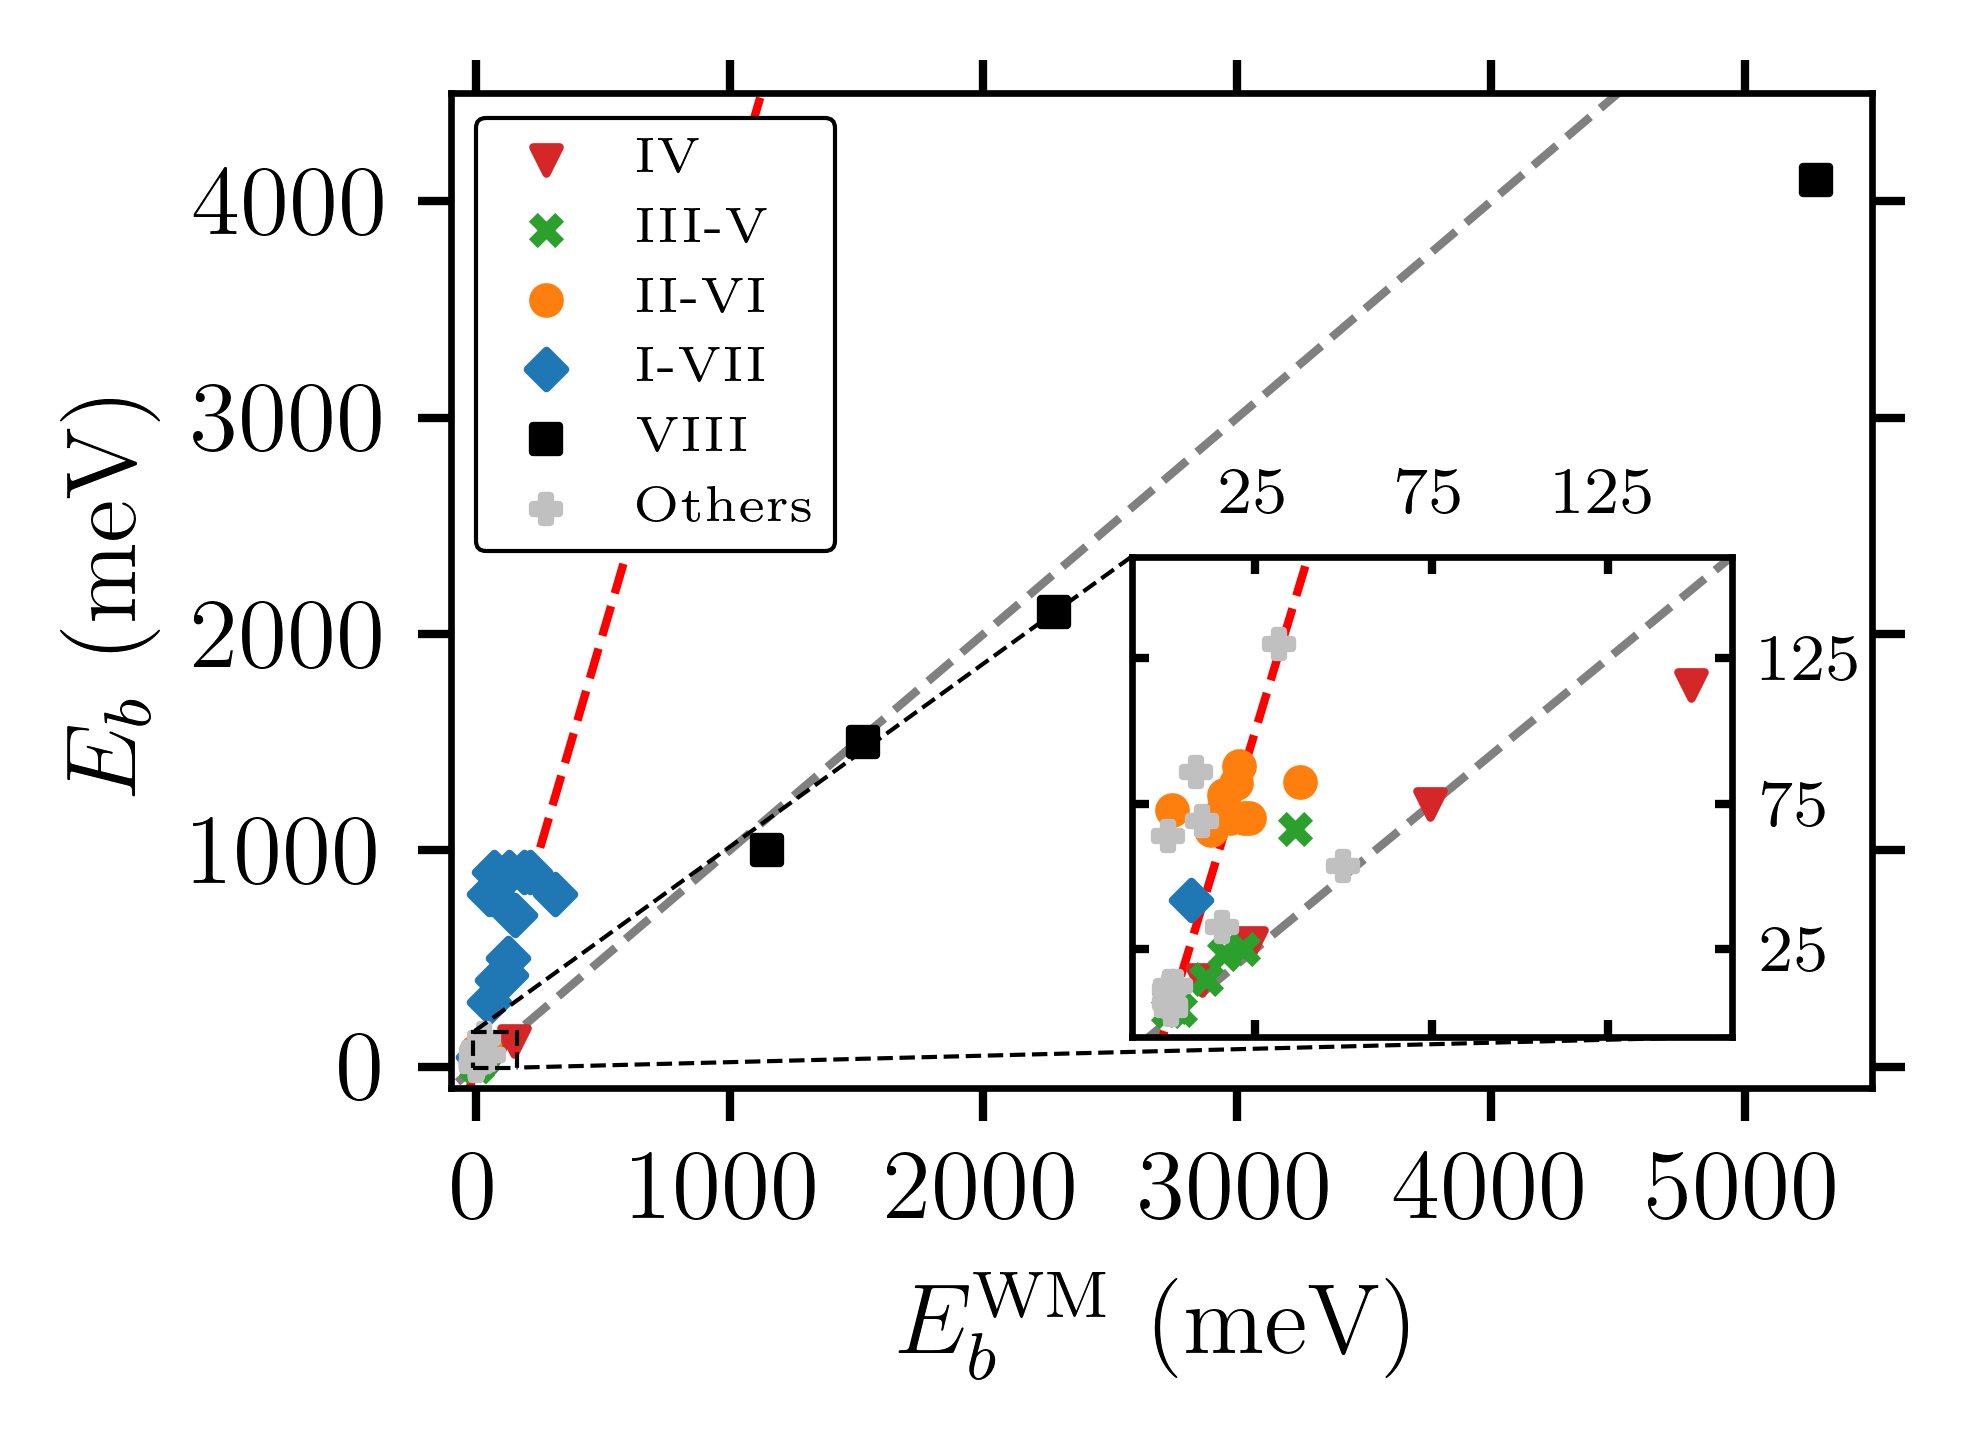

In [ ]:
# figure size (tested)
width = 3 + 3/8
height = 2.5

# text size
fs = 12

# figure
fig, ax = plt.subplots(1, 1, figsize=(width, height), facecolor="w", dpi=600)  

# plot everything
for i,m in enumerate(all_mats):
    ax.scatter(result_df["WM_total"][m], result_df["binding_energy"][m], 
               s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])

# plot the WM model line
ax.plot([-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1)
ax.plot([-1000, 10000], 4*np.array([-1000, 10000]), color="red", linestyle="--", linewidth=1, zorder=-1)

# inset
axins = inset_axes(ax, width=1.0, height=0.8, bbox_to_anchor=(.45, .01, .6, .2),
                   bbox_transform=ax.transAxes, loc=3)

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["WM_total"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# plot the WM model line
axins.plot([-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1)
axins.plot([-1000, 10000], 4*np.array([-1000, 10000]), color="red", linestyle="--", linewidth=1, zorder=-1)

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([-10, 160])
axins.set_ylim([-5, 160])

# axis ticks inset
axins.xaxis.set_ticks([25, 75, 125])
axins.yaxis.set_ticks([25, 75, 125])

# mark the inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")  

# axis ticks
ax.xaxis.set_tick_params(labelsize=fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
               width=1, length=4, direction="out")
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis limits
ax.set_xlim([-100, 5500])
ax.set_ylim([-100, 4500])

# axis ticks 
ax.xaxis.set_ticks([0, 1000, 2000, 3000, 4000, 5000])
ax.yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# axis labels
ax.set_xlabel(r"$E_b^\mathrm{WM}$ (meV)", size=fs)
ax.set_ylabel(r"$E_b$ (meV)", size=fs)

# legend 
leg = ax.legend(loc="upper left", fontsize=6, facecolor="w", edgecolor="k", framealpha=1.0, frameon=True)
leg.get_frame().set_linewidth(0.5)

# fix layout
fig.tight_layout()

# save the figure
fig.savefig("../plots/paper/wm_total_eb.pdf")

C:\Users\grune\AppData\Local\Temp\ipykernel_15564\401961325.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


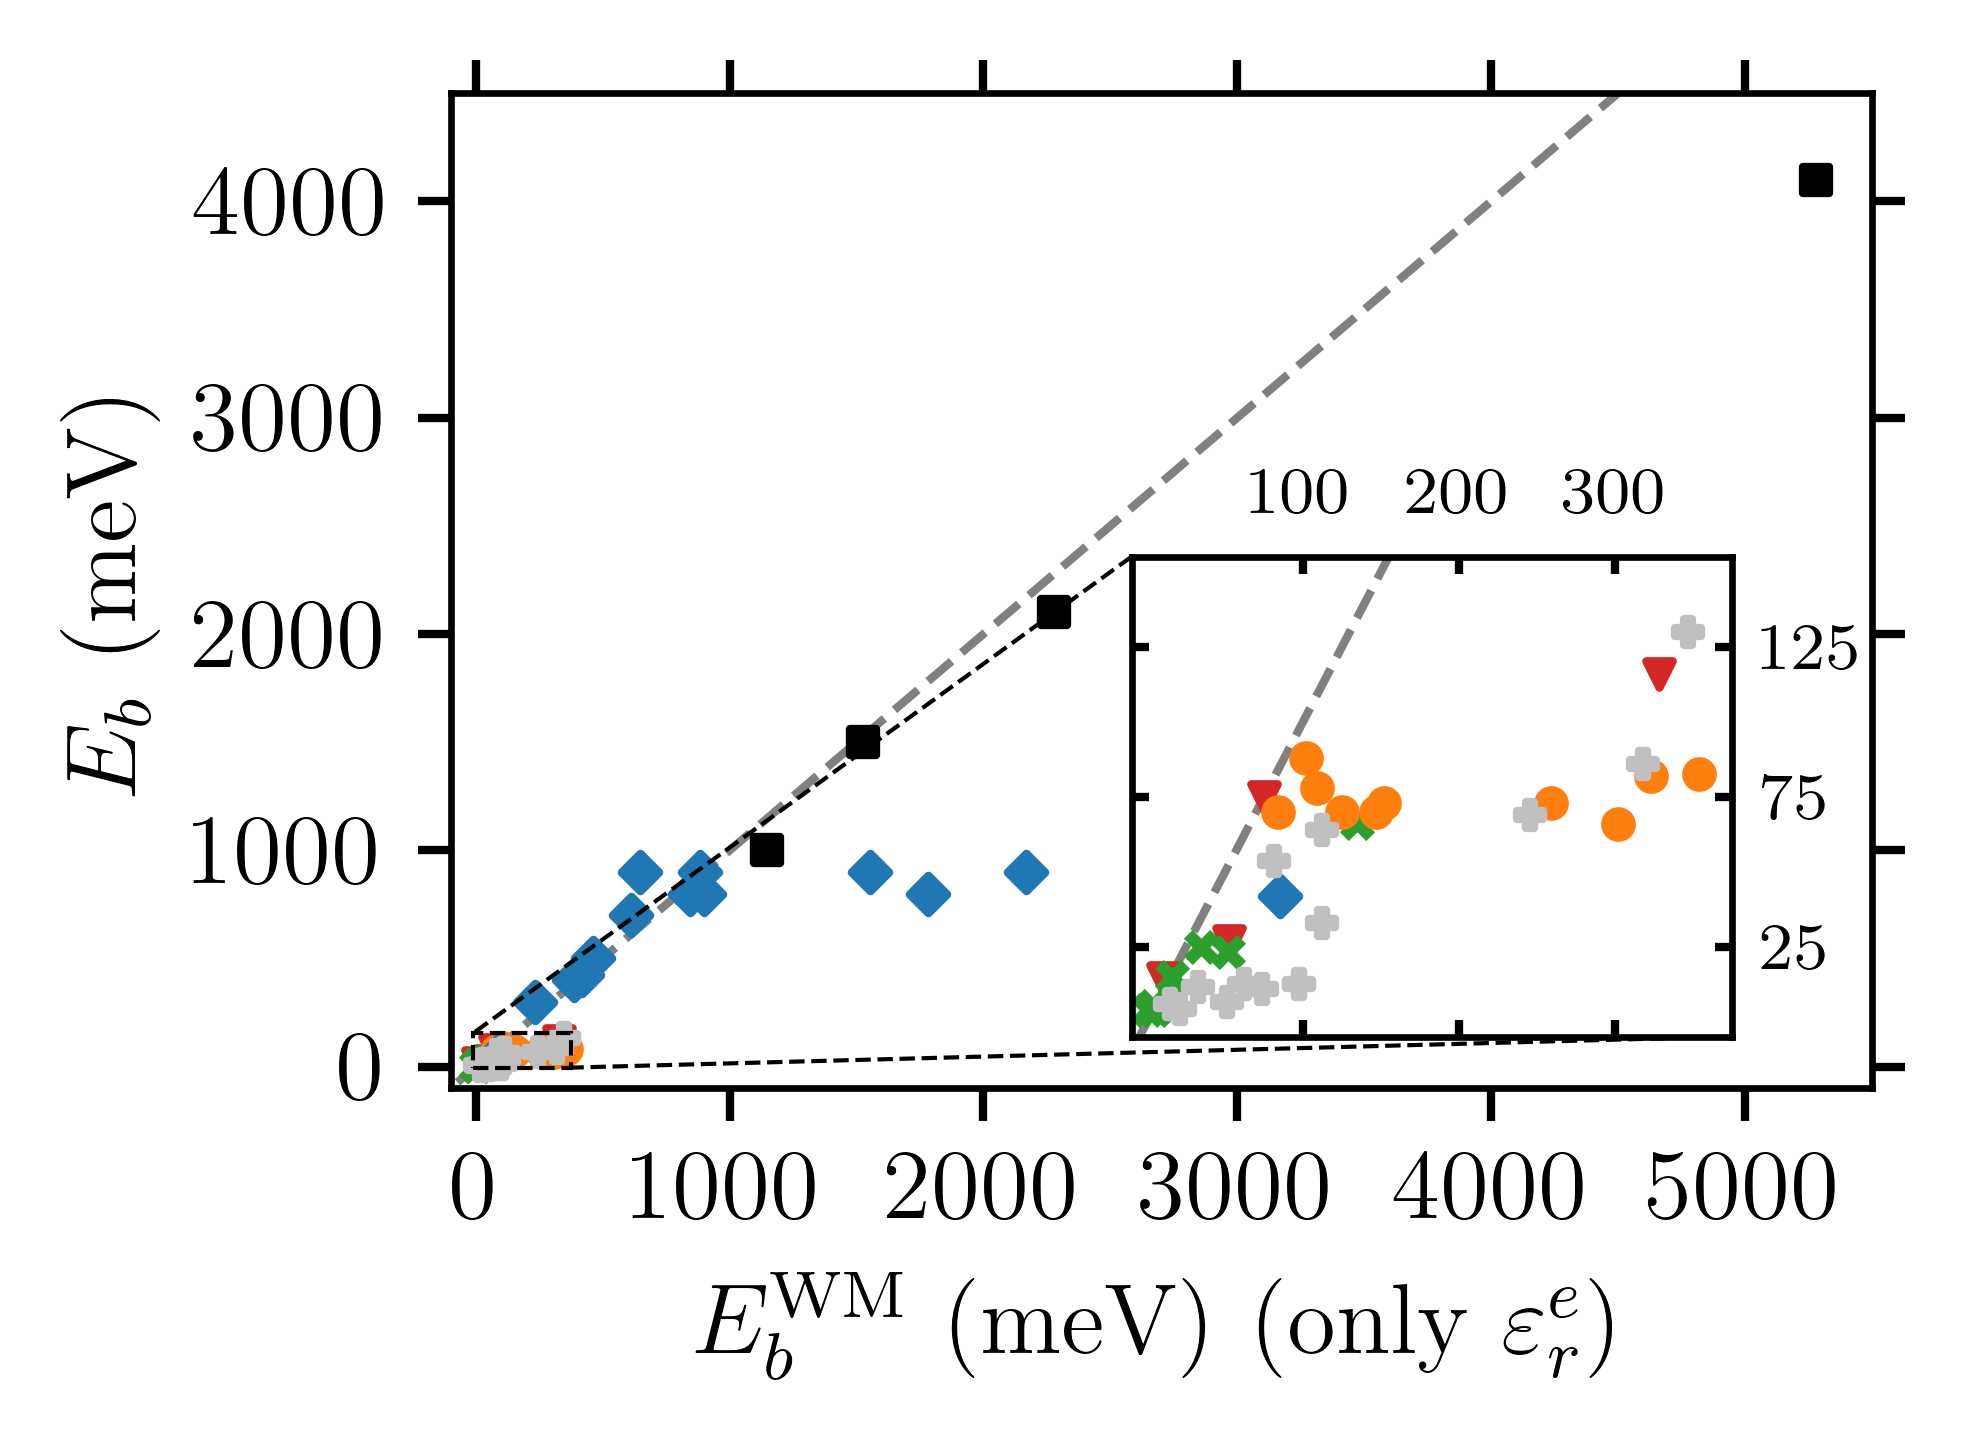

In [ ]:
# figure size (tested)
width = 3 + 3/8
height = 2.5

# text size
fs = 12

# figure
fig, ax = plt.subplots(1, 1, figsize=(width, height), facecolor="w", dpi=600)  

# plot everything
for i,m in enumerate(all_mats):
    ax.scatter(result_df["WM_elec"][m], result_df["binding_energy"][m], 
               s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])

# plot the WM model line
ax.plot([-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1)

# inset
axins = inset_axes(ax, width=1.0, height=0.8, bbox_to_anchor=(.45, .01, .6, .2),
                   bbox_transform=ax.transAxes, loc=3)

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["WM_elec"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# plot the WM model line
axins.plot([-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1)

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([-10, 375])
axins.set_ylim([-5, 155])

# axis ticks inset
axins.xaxis.set_ticks([100, 200, 300])
axins.yaxis.set_ticks([25, 75, 125])

# mark the inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")  

# axis ticks
ax.xaxis.set_tick_params(labelsize=fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
               width=1, length=4, direction="out")
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis limits
ax.set_xlim([-100, 5500])
ax.set_ylim([-100, 4500])

# axis ticks 
ax.xaxis.set_ticks([0, 1000, 2000, 3000, 4000, 5000])
ax.yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# axis labels
ax.set_xlabel(r"$E_b^\mathrm{WM}$ (meV) (only $\varepsilon_r^e$)", size=fs)
ax.set_ylabel(r"$E_b$ (meV)", size=fs)

# fix layout
fig.tight_layout()

# save the figure
fig.savefig("../plots/paper/wm_elec_eb.pdf")

C:\Users\grune\AppData\Local\Temp\ipykernel_15564\560292138.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


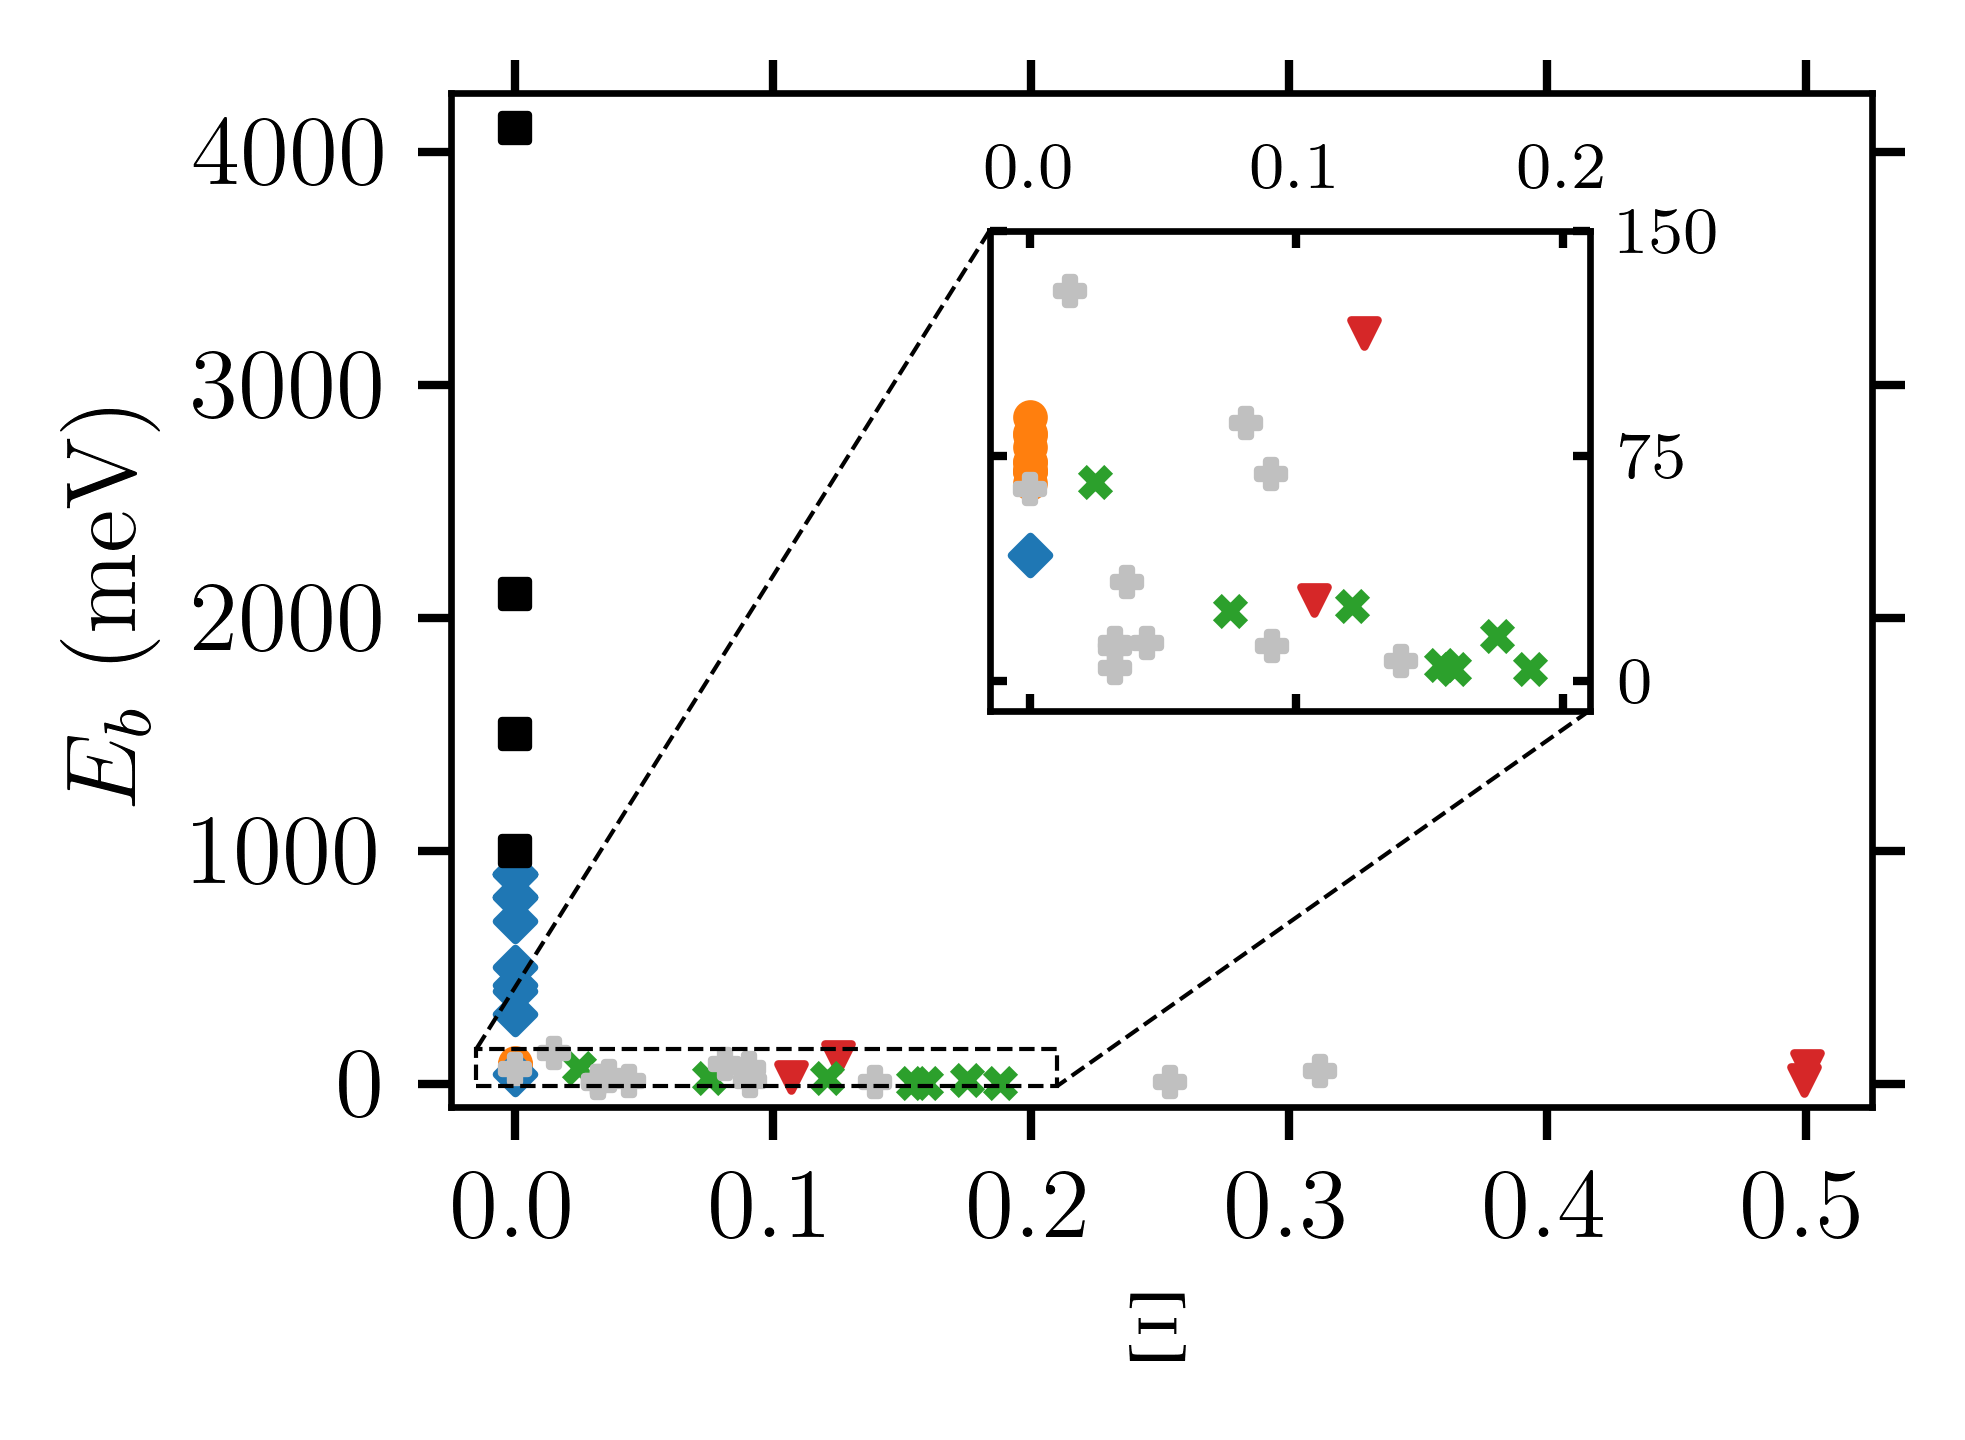

In [ ]:
# figure size (tested)
width = 3 + 3/8
height = 2.5

# text size
fs = 12

# figure
fig, ax = plt.subplots(1, 1, figsize=(width, height), facecolor="w", dpi=600)  

# plot everything
for i,m in enumerate(all_mats):
    ax.scatter(result_df["distance_mean"][m], result_df["binding_energy"][m], 
               s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])
    
# inset
axins = inset_axes(ax, width=1.0, height=0.8, bbox_to_anchor=(.35, .35, .6, .2),
                   bbox_transform=ax.transAxes, loc=3)

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["distance_mean"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([-0.015, 0.21])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.xaxis.set_ticks([0.0, 0.1, 0.2])
axins.yaxis.set_ticks([0, 75, 150])

# mark the inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")    

# axis ticks
ax.xaxis.set_tick_params(labelsize=fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
               width=1, length=4, direction="out")
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis limits  
ax.set_ylim([-100, 4250])

# axis labels
ax.set_xlabel(r"$\Xi$", size=fs)
ax.set_ylabel(r"$E_b$ (meV)", size=fs)

# axis ticks 
ax.xaxis.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

# fix layout
fig.tight_layout()

# save the figure
fig.savefig("../plots/paper/mlwf_eb.pdf")

C:\Users\grune\AppData\Local\Temp\ipykernel_15564\2333652580.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


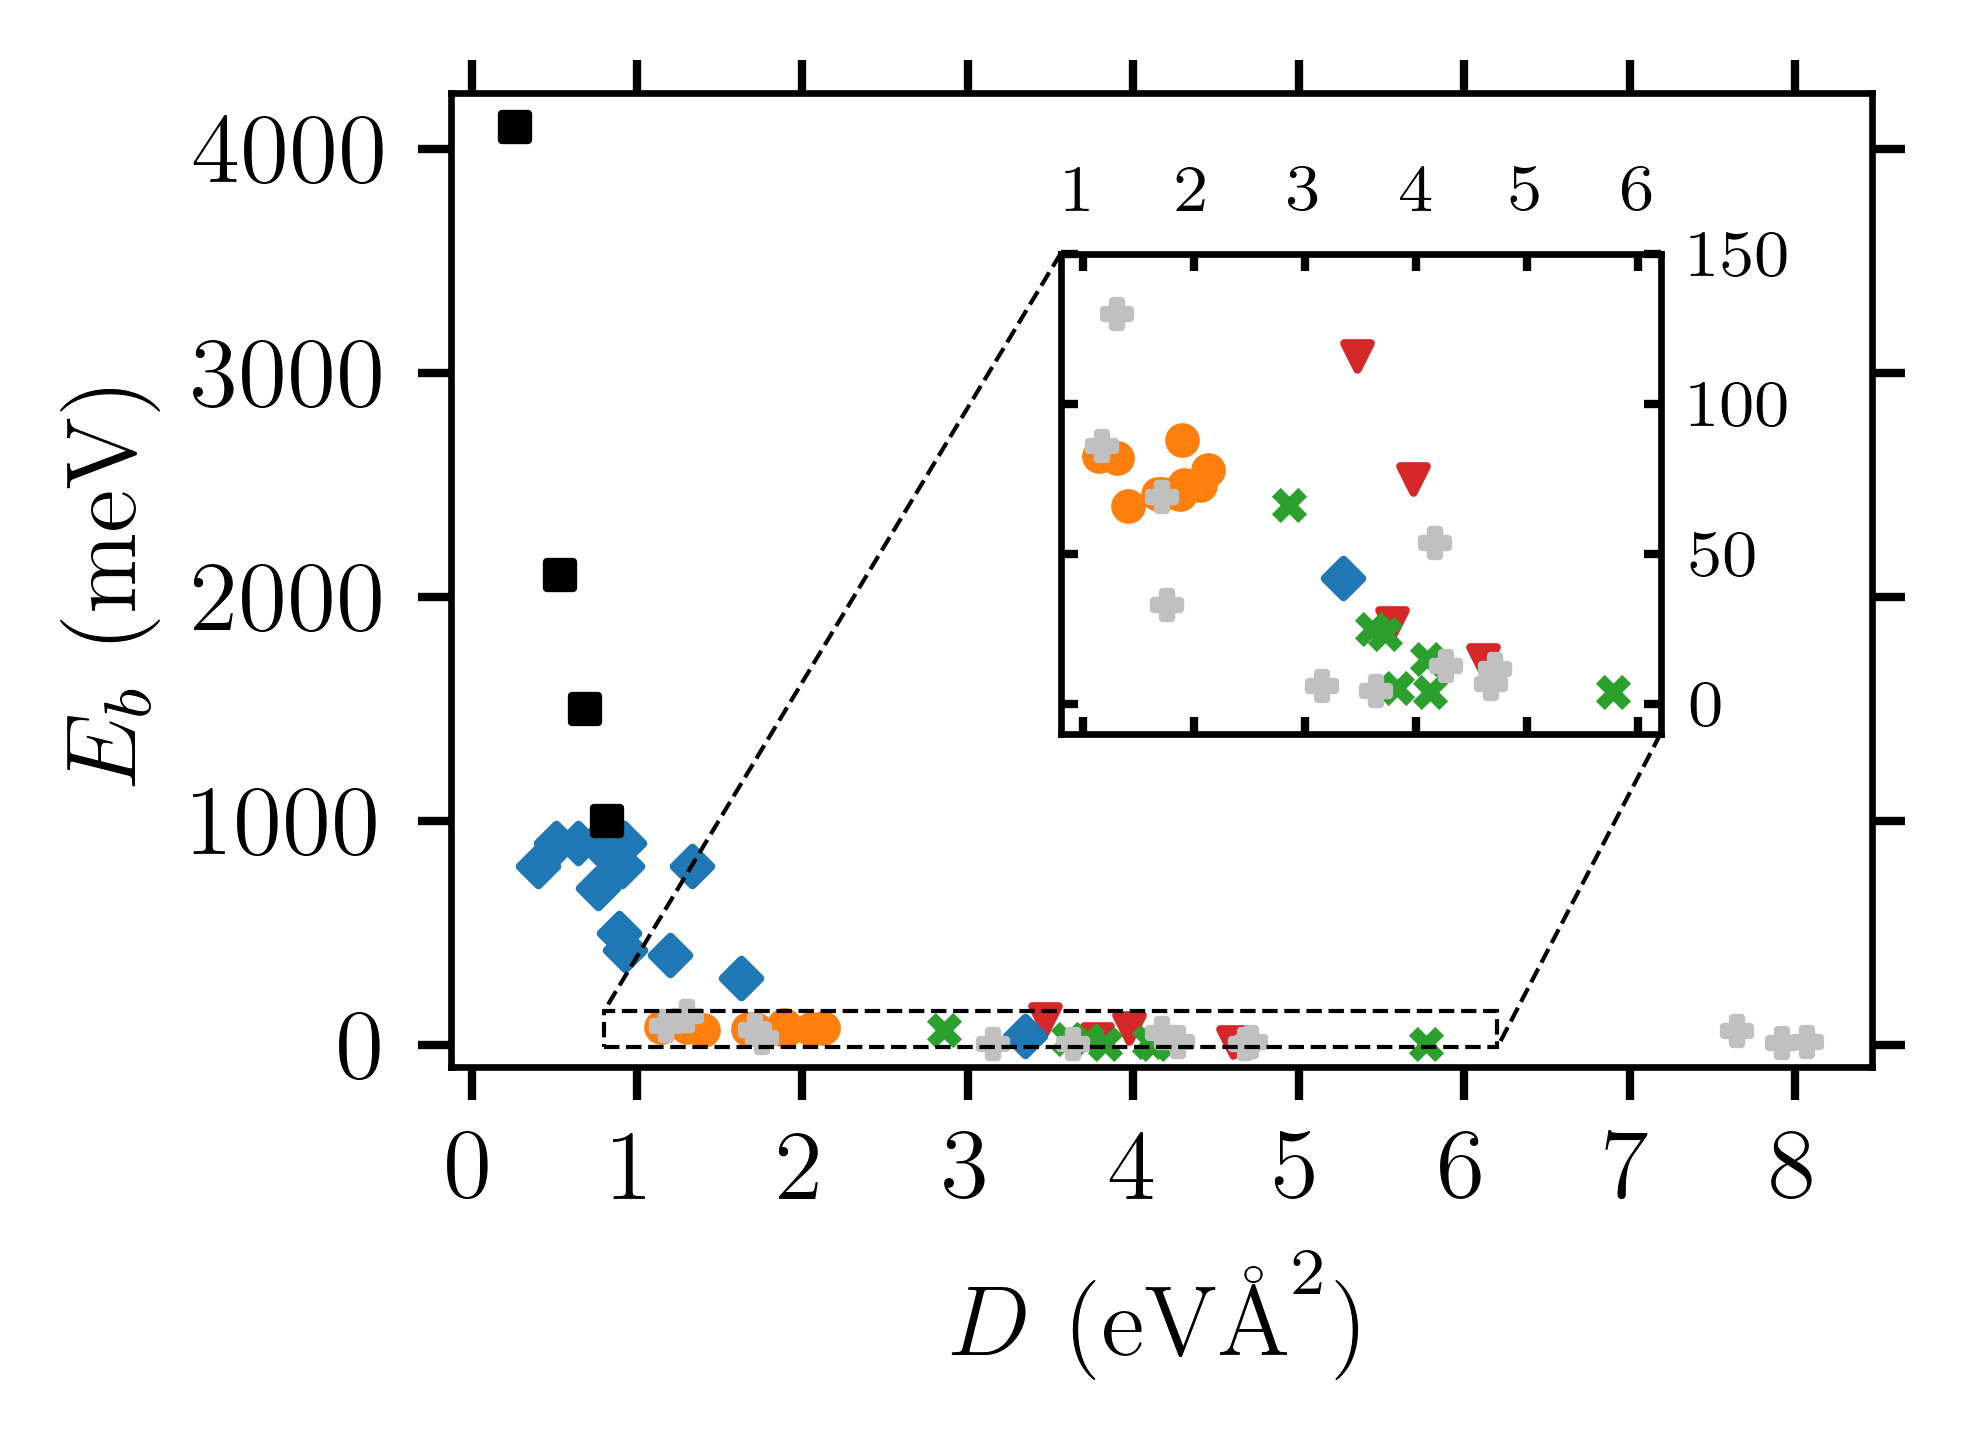

In [ ]:
# figure size (tested)
width = 3 + 3/8
height = 2.5

# text size
fs = 12

# figure
fig, ax = plt.subplots(1, 1, figsize=(width, height), facecolor="w", dpi=600)  

# plot everything
for i,m in enumerate(all_mats):
    ax.scatter(result_df["vbm_deriv"][m], result_df["binding_energy"][m], 
               s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])
    
# inset
axins = inset_axes(ax, width=1.0, height=0.8, bbox_to_anchor=(.4, .3, .6, .2),
                   bbox_transform=ax.transAxes, loc=3)

# mark the inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")    

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["vbm_deriv"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([0.8, 6.2])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.xaxis.set_ticks([1,2, 3, 4, 5, 6]) 
axins.yaxis.set_ticks([0, 50, 100, 150])    

# axis ticks
ax.xaxis.set_tick_params(labelsize=fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
               width=1, length=4, direction="out")
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis limits  
ax.set_ylim([-100, 4250])

# axis labels
ax.set_xlabel(r"$D$ (eV$\textrm{\AA}^2$)", size=fs)
ax.set_ylabel(r"$E_b$ (meV)", size=fs)

# axis ticks 
ax.xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# fix layout
fig.tight_layout()

# save the figure
fig.savefig("../plots/paper/vbm_deriv_eb.pdf")

C:\Users\grune\AppData\Local\Temp\ipykernel_15564\2077736197.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


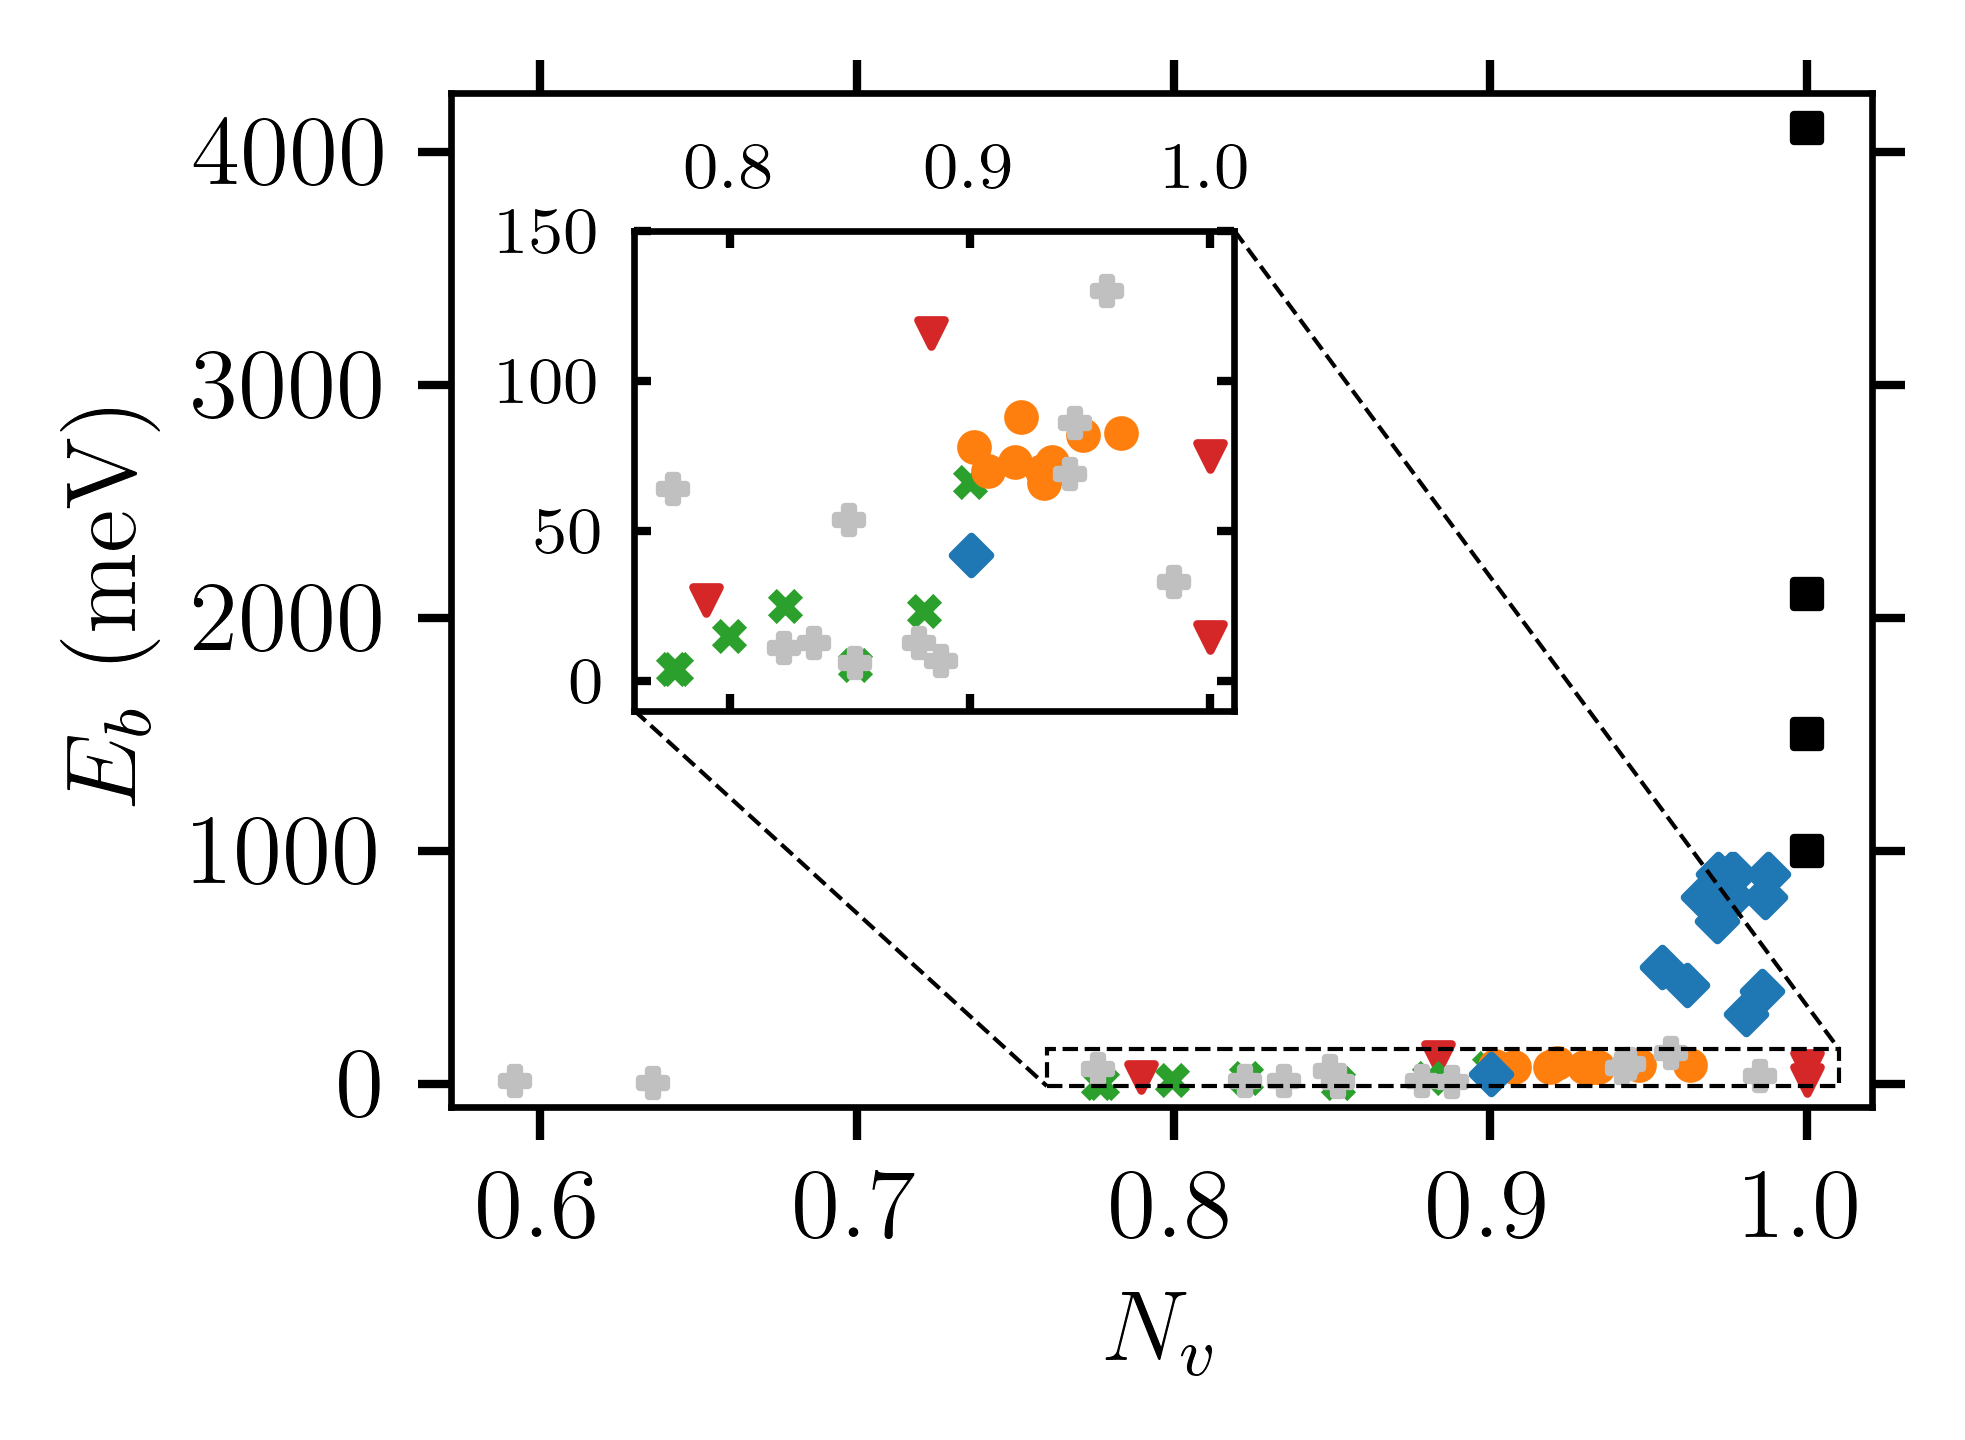

In [ ]:
# figure size (tested)
width = 3 + 3/8
height = 2.5

# text size
fs = 12

# figure
fig, ax = plt.subplots(1, 1, figsize=(width, height), facecolor="w", dpi=600)  

# plot everything
for i,m in enumerate(all_mats):
    ax.scatter(result_df["nv"][m], result_df["binding_energy"][m], 
               s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])

# inset
axins = inset_axes(ax, width=1.0, height=0.8, bbox_to_anchor=(.1, .35, .6, .2),
                   bbox_transform=ax.transAxes, loc=3)

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["nv"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)

# axis limits inset 
axins.set_xlim([0.76, 1.01])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.yaxis.set_ticks([0, 50, 100, 150])

# mark the inset
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="k", linewidth=0.5, linestyle="--")  

# axis ticks
ax.xaxis.set_tick_params(labelsize=fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
               width=1, length=4, direction="out")
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.xaxis.set_ticks([0.6, 0.7, 0.8, 0.9, 1.0])

# axis limits  
ax.set_ylim([-100, 4250])

# axis labels
ax.set_xlabel(r"$N_v$", size=fs)
ax.set_ylabel(r"$E_b$ (meV)", size=fs)

# fix layout
fig.tight_layout()

# save the figure
fig.savefig("../plots/paper/nv_eb.pdf")

C:\Users\grune\AppData\Local\Temp\ipykernel_15564\3007522299.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


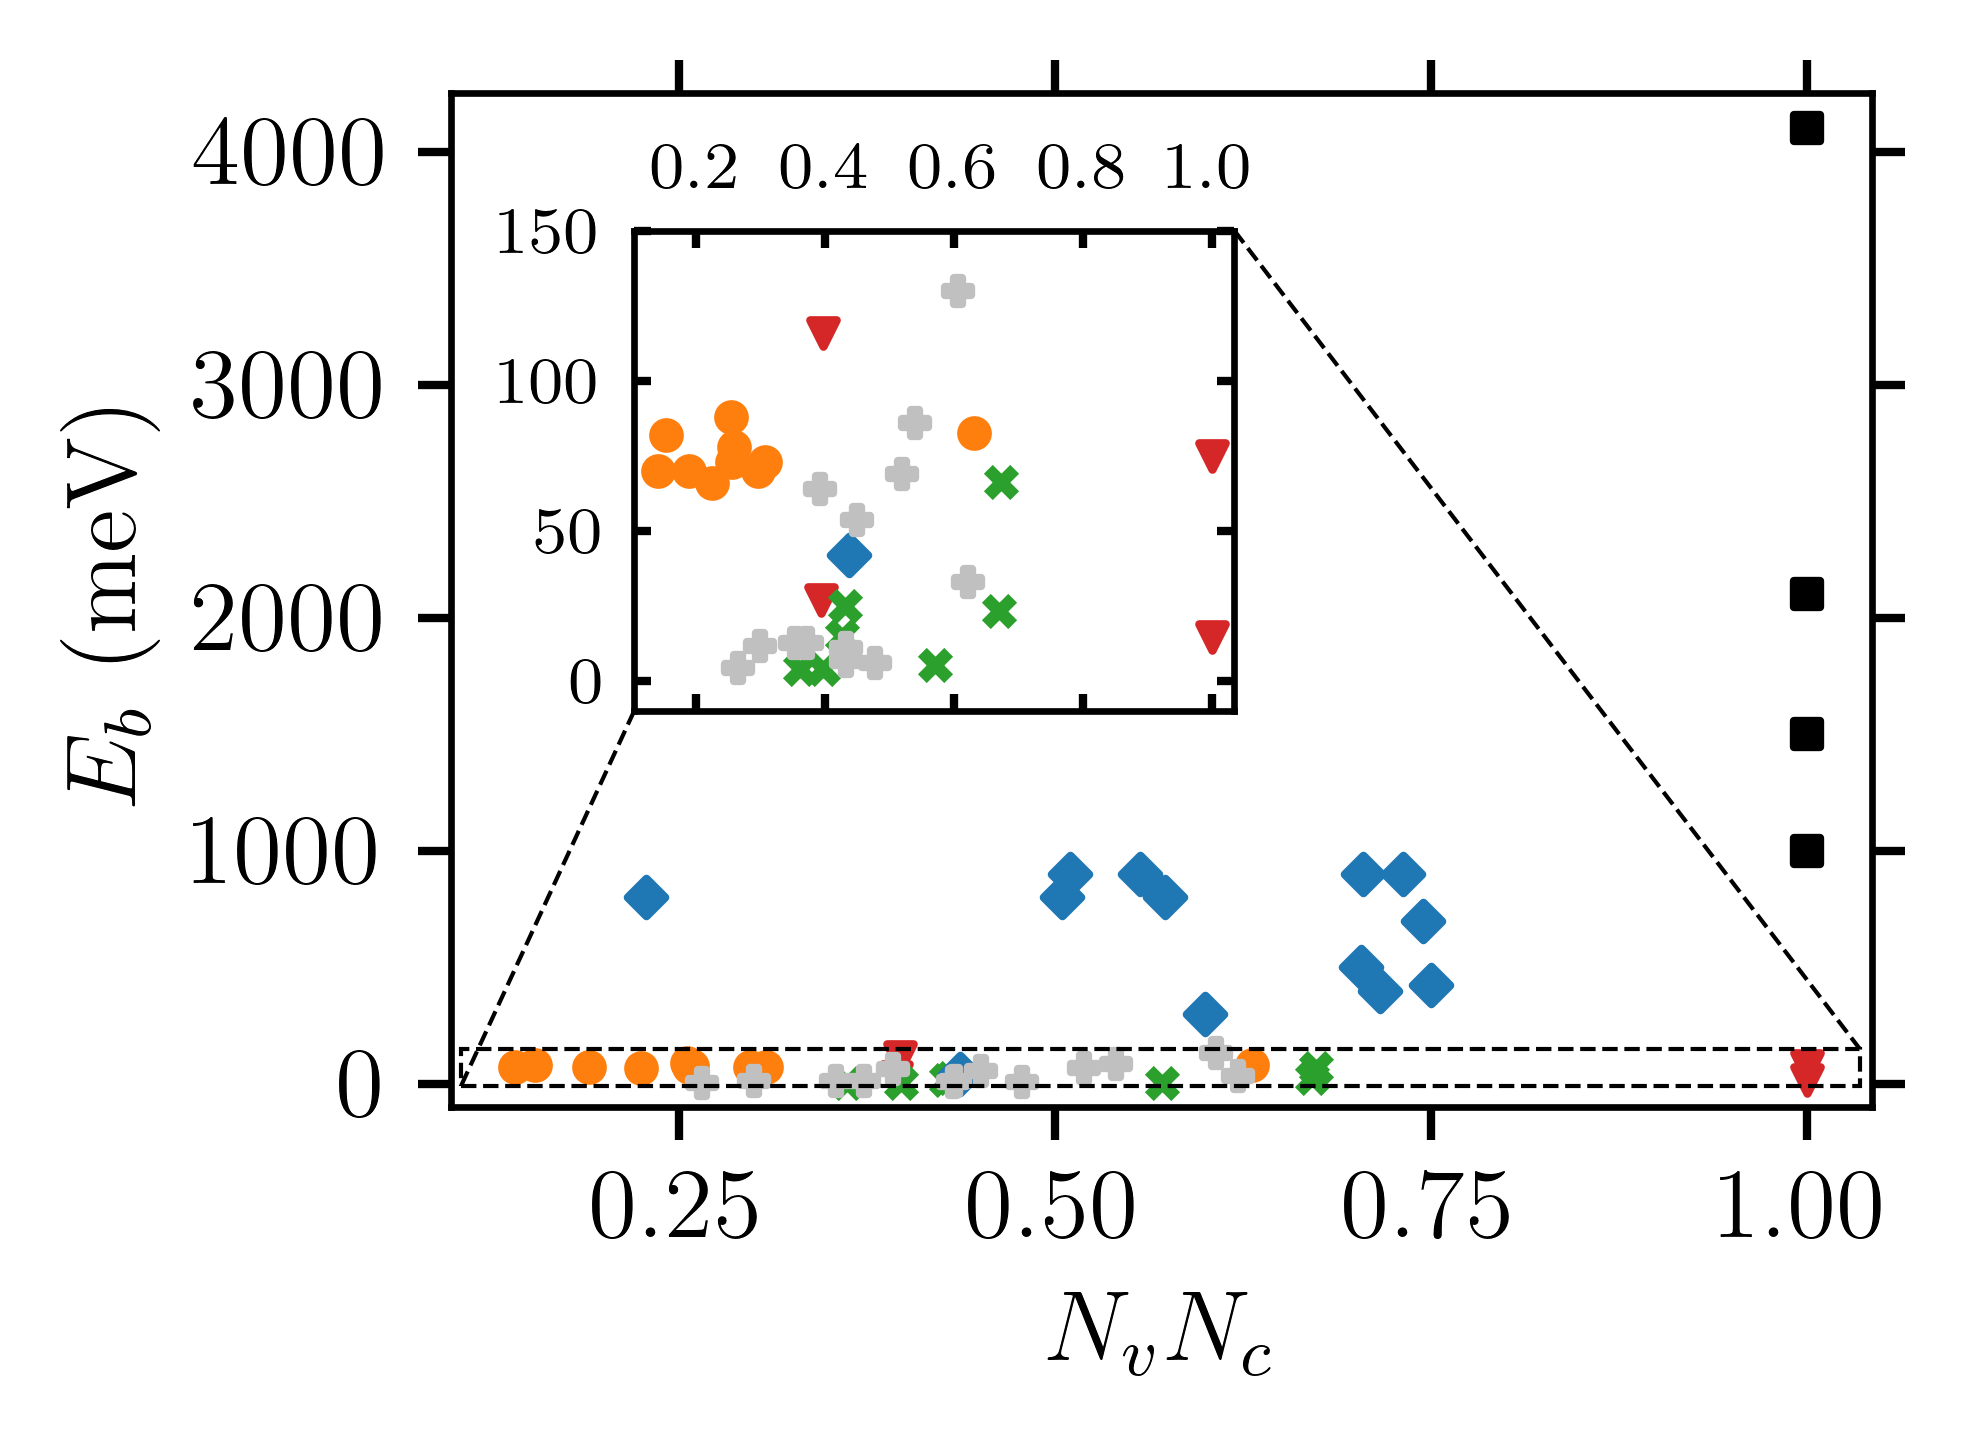

In [ ]:
# figure size (tested)
width = 3 + 3/8
height = 2.5

# text size
fs = 12

# figure
fig, ax = plt.subplots(1, 1, figsize=(width, height), facecolor="w", dpi=600)  

# plot everything
for i,m in enumerate(all_mats):
    ax.scatter(result_df["nvnc"][m], result_df["binding_energy"][m], 
               s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])

# inset
axins = inset_axes(ax, width=1.0, height=0.8, bbox_to_anchor=(.1, .35, .6, .2),
                   bbox_transform=ax.transAxes, loc=3)

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["nvnc"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)

# axis limits inset 
axins.set_xlim([0.105, 1.035])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.xaxis.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
axins.yaxis.set_ticks([0, 50, 100, 150])

# mark the inset
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="k", linewidth=0.5, linestyle="--")  

# axis ticks
ax.xaxis.set_tick_params(labelsize=fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
               width=1, length=4, direction="out")
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis limits  
ax.set_ylim([-100, 4250])

# axis labels
ax.set_xlabel(r"$N_vN_c$", size=fs)
ax.set_ylabel(r"$E_b$ (meV)", size=fs)

# fix layout
fig.tight_layout()

# save the figure
fig.savefig("../plots/paper/nvnc_eb.pdf")

C:\Users\grune\AppData\Local\Temp\ipykernel_15564\1771128295.py:345: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


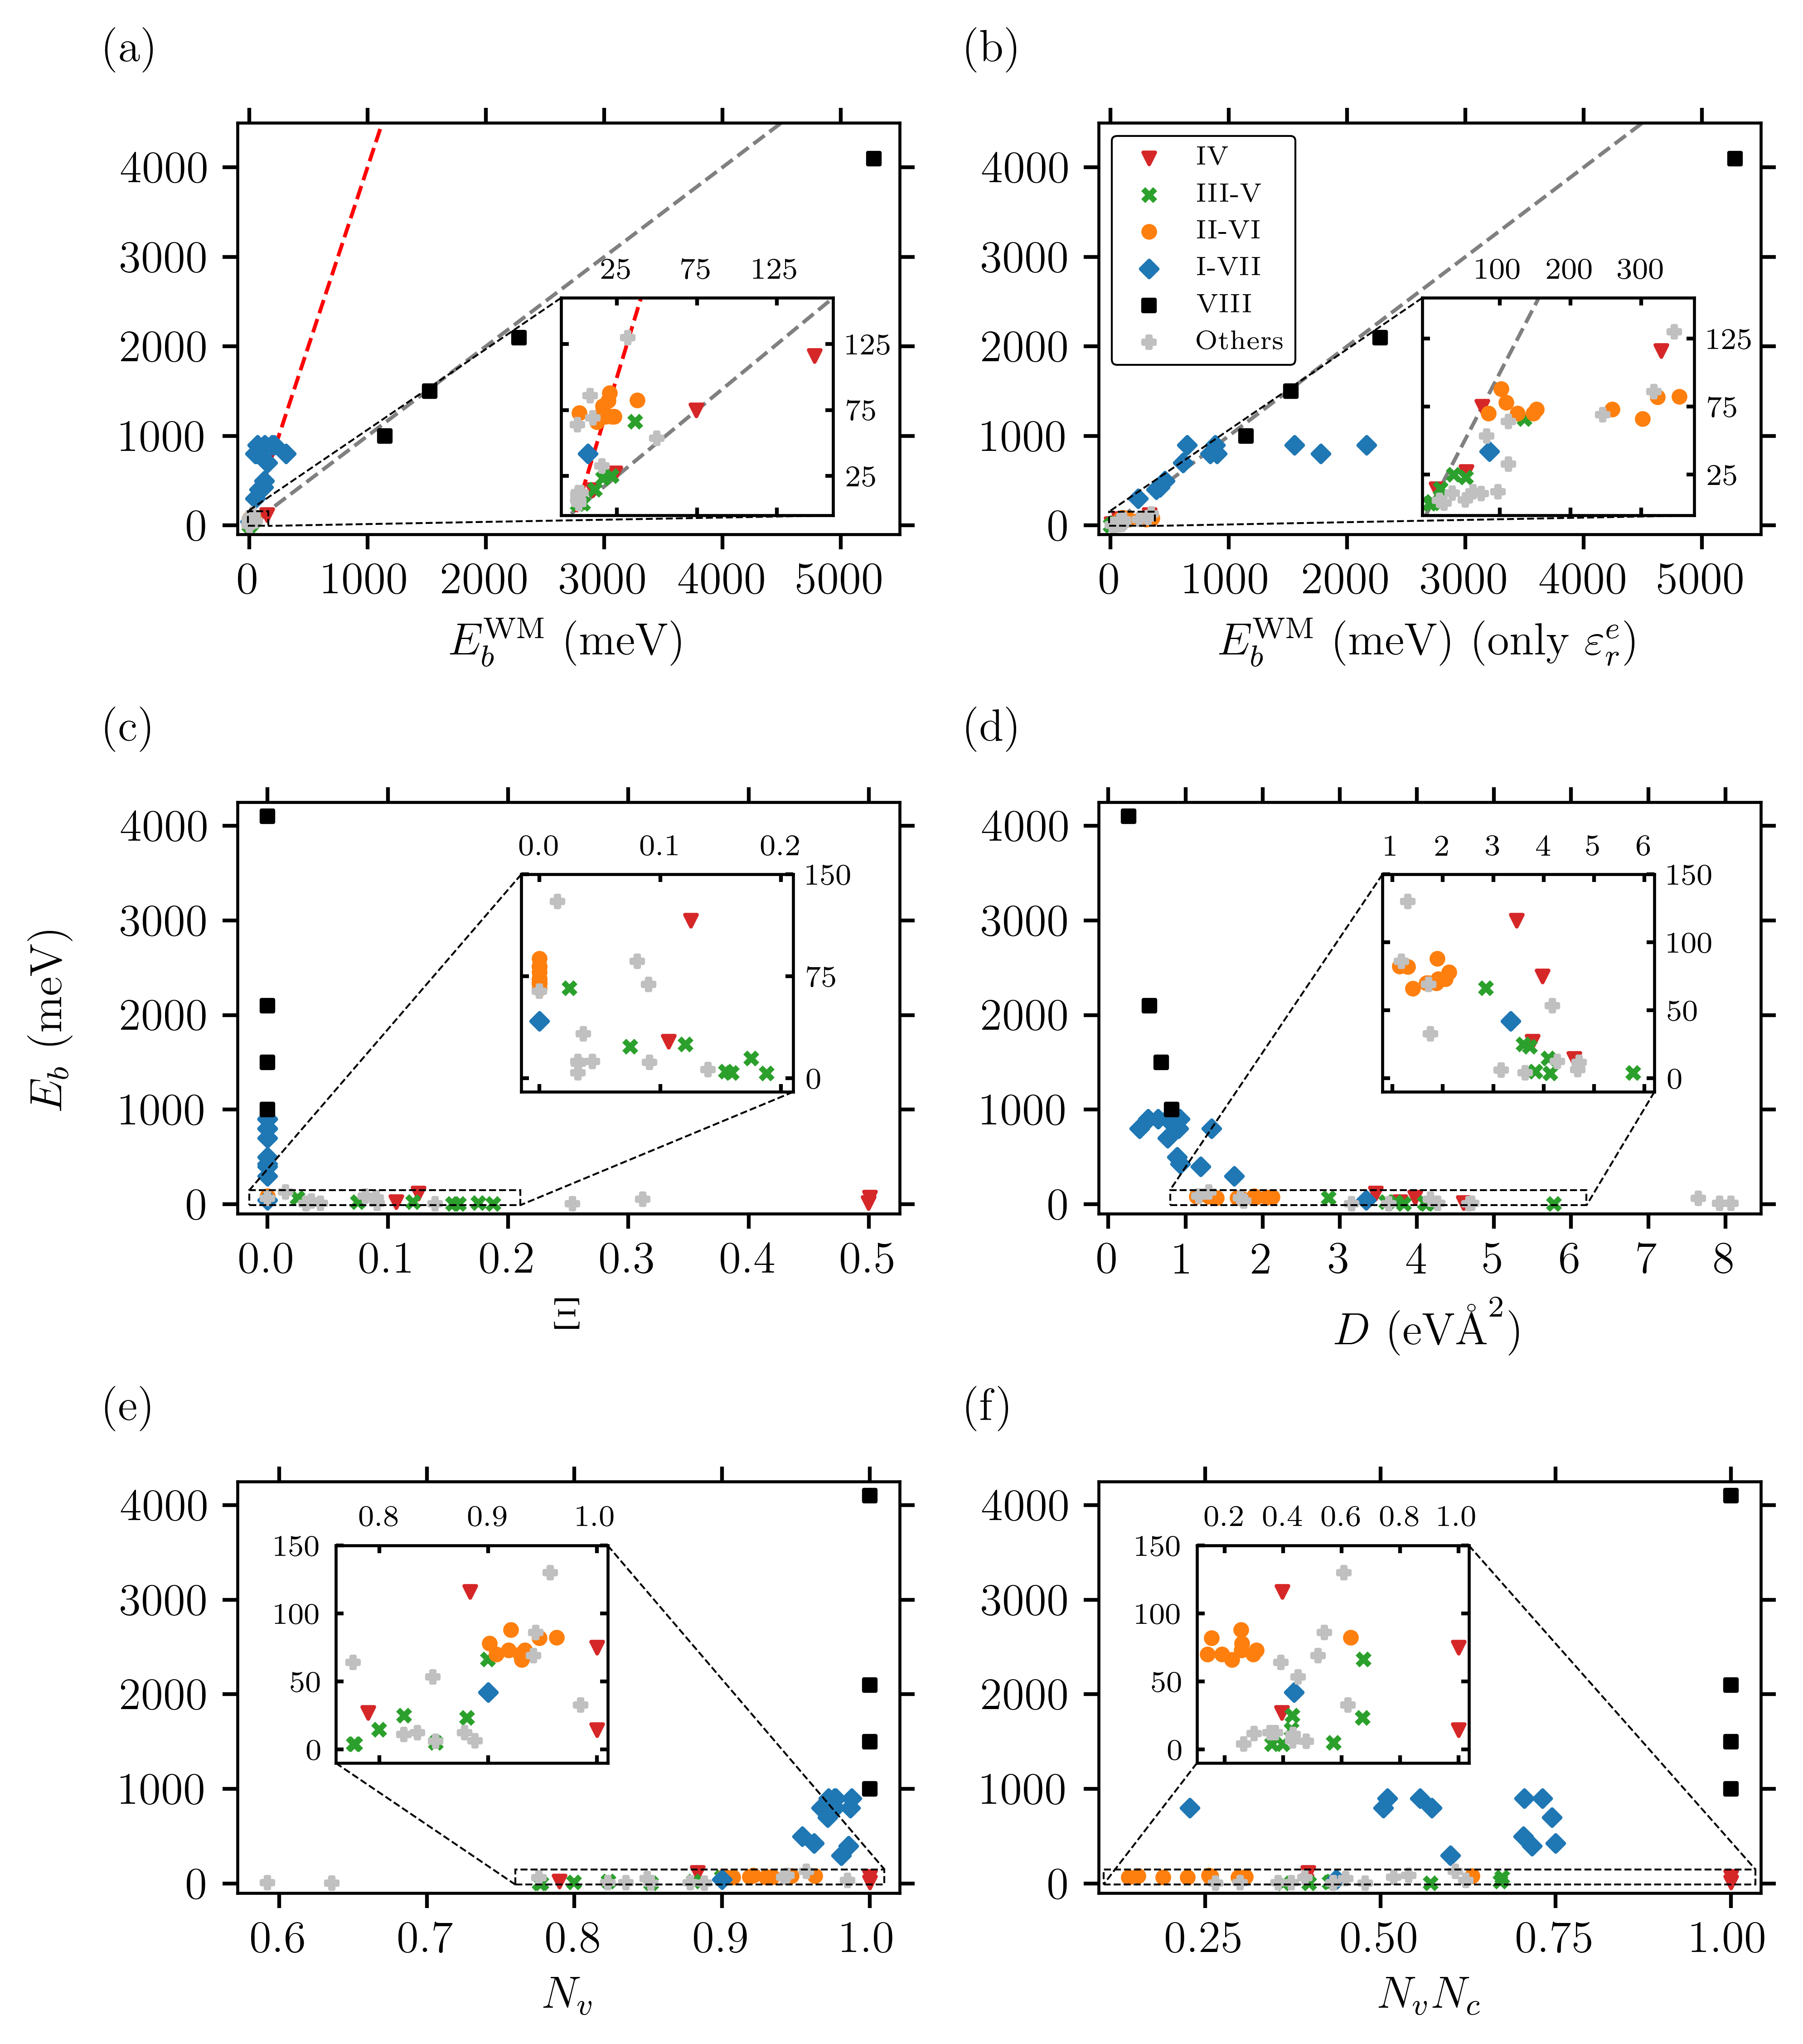

In [ ]:
# figure size (tested)
width = (3 + 3/8) * 2
height = 2.55 * 3

# text size
fs = 12

# figure
fig, axes = plt.subplots(3, 2, figsize=(width, height), facecolor="w", dpi=600)  

# figure y-label
fig.supylabel(r"$E_b$ (meV)", x=0.025, y=0.5, size=fs)

# add (a), (b), (c), ... to the subplots
axes[0,0].text(-0.2, 1.15, r"(a)", transform=axes[0,0].transAxes, size=fs)
axes[0,1].text(-0.2, 1.15, r"(b)", transform=axes[0,1].transAxes, size=fs)
axes[1,0].text(-0.2, 1.15, r"(c)", transform=axes[1,0].transAxes, size=fs)
axes[1,1].text(-0.2, 1.15, r"(d)", transform=axes[1,1].transAxes, size=fs)
axes[2,0].text(-0.2, 1.15, r"(e)", transform=axes[2,0].transAxes, size=fs)
axes[2,1].text(-0.2, 1.15, r"(f)", transform=axes[2,1].transAxes, size=fs)

""""""

# plot everything
for i,m in enumerate(all_mats):
    axes[0,0].scatter(result_df["WM_total"][m], result_df["binding_energy"][m], 
                      s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])

# plot the WM model line
axes[0,0].plot([-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1)
axes[0,0].plot([-1000, 10000], 4*np.array([-1000, 10000]), color="red", linestyle="--", linewidth=1, zorder=-1)

# inset
axins = inset_axes(axes[0,0], width=1.0, height=0.8, bbox_to_anchor=(.46, .0, .6, .2),
                   bbox_transform=axes[0,0].transAxes, loc=3)

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["WM_total"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# plot the WM model line
axins.plot([-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1)
axins.plot([-1000, 10000], 4*np.array([-1000, 10000]), color="red", linestyle="--", linewidth=1, zorder=-1)

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([-10, 160])
axins.set_ylim([-5, 160])

# axis ticks inset
axins.xaxis.set_ticks([25, 75, 125])
axins.yaxis.set_ticks([25, 75, 125])

# mark the inset
mark_inset(axes[0,0], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")  

# axis ticks
axes[0,0].xaxis.set_tick_params(labelsize=fs)
axes[0,0].yaxis.set_tick_params(labelsize=fs)
axes[0,0].tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                      width=1, length=4, direction="out")
axes[0,0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis limits
axes[0,0].set_xlim([-100, 5500])
axes[0,0].set_ylim([-100, 4500])

# axis ticks 
axes[0,0].xaxis.set_ticks([0, 1000, 2000, 3000, 4000, 5000])
axes[0,0].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# axis labels
axes[0,0].set_xlabel(r"$E_b^\mathrm{WM}$ (meV)", size=fs)

""""""

# plot everything
for i,m in enumerate(all_mats):
    axes[0,1].scatter(result_df["WM_elec"][m], result_df["binding_energy"][m], 
                      s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])

# plot the WM model line
axes[0,1].plot([-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1)

# inset
axins = inset_axes(axes[0,1], width=1.0, height=0.8, bbox_to_anchor=(.46, .0, .6, .2),
                   bbox_transform=axes[0,1].transAxes, loc=3)

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["WM_elec"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# plot the WM model line
axins.plot([-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1)

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([-10, 375])
axins.set_ylim([-5, 155])

# axis ticks inset
axins.xaxis.set_ticks([100, 200, 300])
axins.yaxis.set_ticks([25, 75, 125])

# mark the inset
mark_inset(axes[0,1], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")  

# axis ticks
axes[0,1].xaxis.set_tick_params(labelsize=fs)
axes[0,1].yaxis.set_tick_params(labelsize=fs)
axes[0,1].tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                      width=1, length=4, direction="out")
axes[0,1].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis limits
axes[0,1].set_xlim([-100, 5500])
axes[0,1].set_ylim([-100, 4500])

# axis ticks 
axes[0,1].xaxis.set_ticks([0, 1000, 2000, 3000, 4000, 5000])
axes[0,1].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# axis labels
axes[0,1].set_xlabel(r"$E_b^\mathrm{WM}$ (meV) (only $\varepsilon_r^e$)", size=fs)

# legend 
leg = axes[0,1].legend(loc="upper left", fontsize=7, facecolor="w", edgecolor="k", framealpha=1.0, frameon=True)
leg.get_frame().set_linewidth(0.5)

""""""

# plot everything
for i,m in enumerate(all_mats):
    axes[1,0].scatter(result_df["distance_mean"][m], result_df["binding_energy"][m], 
                      s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])
    
# inset
axins = inset_axes(axes[1,0], width=1.0, height=0.8, bbox_to_anchor=(.4, .25, .6, .2),
                   bbox_transform=axes[1,0].transAxes, loc=3)

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["distance_mean"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([-0.015, 0.21])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.xaxis.set_ticks([0.0, 0.1, 0.2])
axins.yaxis.set_ticks([0, 75, 150])

# mark the inset
mark_inset(axes[1,0], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")    

# axis ticks
axes[1,0].xaxis.set_tick_params(labelsize=fs)
axes[1,0].yaxis.set_tick_params(labelsize=fs)
axes[1,0].tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                      width=1, length=4, direction="out")
axes[1,0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis limits  
axes[1,0].set_ylim([-100, 4250])

# axis labels
axes[1,0].set_xlabel(r"$\Xi$", size=fs)

# axis ticks 
axes[1,0].xaxis.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
axes[1,0].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

""""""

# plot everything
for i,m in enumerate(all_mats):
    axes[1,1].scatter(result_df["vbm_deriv"][m], result_df["binding_energy"][m], 
                      s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])
    
# inset
axins = inset_axes(axes[1,1], width=1.0, height=0.8, bbox_to_anchor=(.4, .25, .6, .2),
                   bbox_transform=axes[1,1].transAxes, loc=3)

# mark the inset
mark_inset(axes[1,1], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")    

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["vbm_deriv"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([0.8, 6.2])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.xaxis.set_ticks([1,2, 3, 4, 5, 6]) 
axins.yaxis.set_ticks([0, 50, 100, 150])    

# axis ticks
axes[1,1].xaxis.set_tick_params(labelsize=fs)
axes[1,1].yaxis.set_tick_params(labelsize=fs)
axes[1,1].tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                      width=1, length=4, direction="out")
axes[1,1].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis limits  
axes[1,1].set_ylim([-100, 4250])

# axis labels
axes[1,1].set_xlabel(r"$D$ (eV$\textrm{\AA}^2$)", size=fs)

# axis ticks 
axes[1,1].xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
axes[1,1].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

""""""

# plot everything
for i,m in enumerate(all_mats):
    axes[2,0].scatter(result_df["nv"][m], result_df["binding_energy"][m], 
                      s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])

# inset
axins = inset_axes(axes[2,0], width=1.0, height=0.8, bbox_to_anchor=(.12, .27, .6, .2),
                   bbox_transform=axes[2,0].transAxes, loc=3)

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["nv"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)

# axis limits inset 
axins.set_xlim([0.76, 1.01])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.yaxis.set_ticks([0, 50, 100, 150])

# mark the inset
mark_inset(axes[2,0], axins, loc1=1, loc2=3, fc="none", ec="k", linewidth=0.5, linestyle="--")  

# axis ticks
axes[2,0].xaxis.set_tick_params(labelsize=fs)
axes[2,0].yaxis.set_tick_params(labelsize=fs)
axes[2,0].tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                      width=1, length=4, direction="out")
axes[2,0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
axes[2,0].xaxis.set_ticks([0.6, 0.7, 0.8, 0.9, 1.0])
axes[2,0].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# axis limits  
axes[2,0].set_ylim([-100, 4250])

# axis labels
axes[2,0].set_xlabel(r"$N_v$", size=fs)

""""""

# plot everything
for i,m in enumerate(all_mats):
    axes[2,1].scatter(result_df["nvnc"][m], result_df["binding_energy"][m], 
                      s=marker_size, c=all_colors[i], marker=all_markers[i], label=all_labels[i])

# inset
axins = inset_axes(axes[2,1], width=1.0, height=0.8, bbox_to_anchor=(.12, .27, .6, .2),
                   bbox_transform=axes[2,1].transAxes, loc=3)

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["nvnc"][m], result_df["binding_energy"][m], 
                  s=marker_size, c=all_colors[i], marker=all_markers[i])

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)

# axis limits inset 
axins.set_xlim([0.105, 1.035])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.xaxis.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
axins.yaxis.set_ticks([0, 50, 100, 150])

# mark the inset
mark_inset(axes[2,1], axins, loc1=1, loc2=3, fc="none", ec="k", linewidth=0.5, linestyle="--")  

# axis ticks
axes[2,1].xaxis.set_tick_params(labelsize=fs)
axes[2,1].yaxis.set_tick_params(labelsize=fs)
axes[2,1].tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                      width=1, length=4, direction="out")
axes[2,1].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
axes[2,1].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# axis limits  
axes[2,1].set_ylim([-100, 4250])

# axis labels
axes[2,1].set_xlabel(r"$N_vN_c$", size=fs)

""""""

# fix layout
fig.tight_layout()
plt.subplots_adjust(hspace=0.65, wspace=0.3)

# save the figure
fig.savefig("../plots/paper/1d_relations.pdf")

KeyError: 'binding_energy_std'

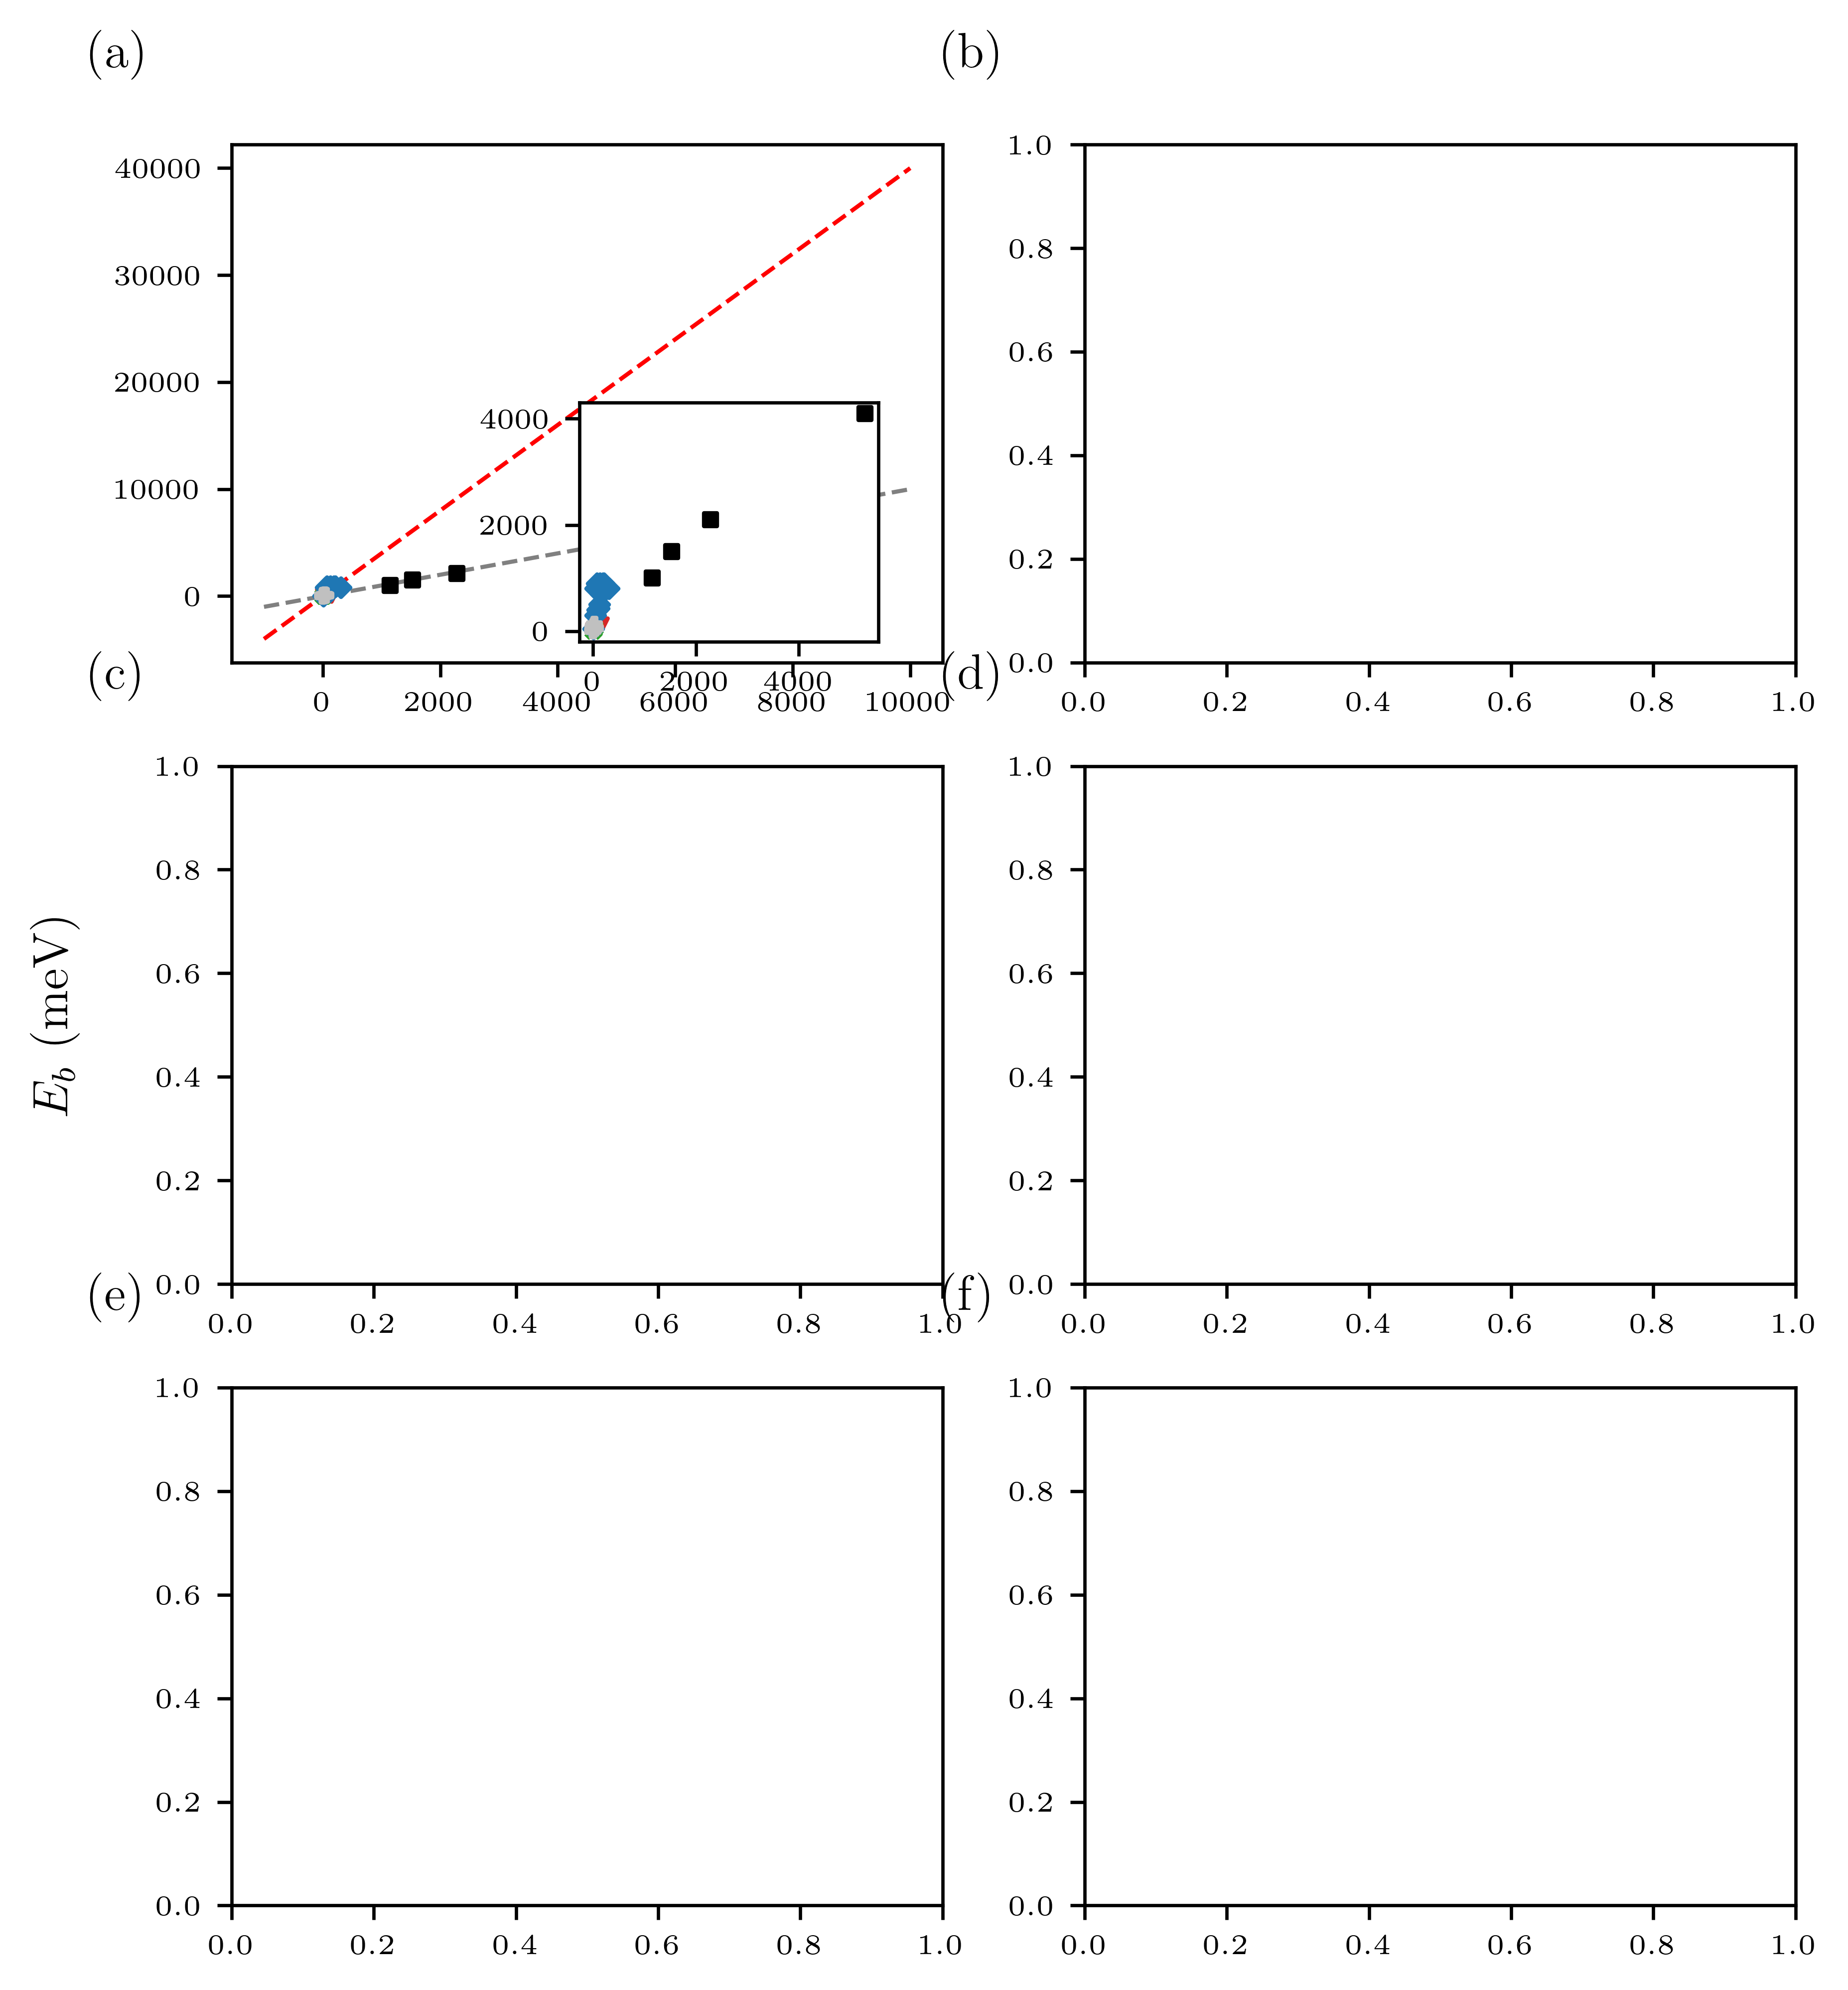

In [ ]:
# figure size (tested)
width = (3 + 3 / 8) * 2
height = 2.55 * 3

# text size
fs = 12

# figure
fig, axes = plt.subplots(3, 2, figsize=(width, height), facecolor="w", dpi=600)

# figure y-label
fig.supylabel(r"$E_b$ (meV)", x=0.025, y=0.5, size=fs)

# add (a), (b), (c), ... to the subplots
axes[0, 0].text(-0.2, 1.15, r"(a)", transform=axes[0, 0].transAxes, size=fs)
axes[0, 1].text(-0.2, 1.15, r"(b)", transform=axes[0, 1].transAxes, size=fs)
axes[1, 0].text(-0.2, 1.15, r"(c)", transform=axes[1, 0].transAxes, size=fs)
axes[1, 1].text(-0.2, 1.15, r"(d)", transform=axes[1, 1].transAxes, size=fs)
axes[2, 0].text(-0.2, 1.15, r"(e)", transform=axes[2, 0].transAxes, size=fs)
axes[2, 1].text(-0.2, 1.15, r"(f)", transform=axes[2, 1].transAxes, size=fs)

""""""

# plot everything
for i, m in enumerate(all_mats):
    axes[0, 0].scatter(
        result_df["WM_total"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
        label=all_labels[i],
    )

# plot the WM model line
axes[0, 0].plot(
    [-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1
)
axes[0, 0].plot(
    [-1000, 10000],
    4 * np.array([-1000, 10000]),
    color="red",
    linestyle="--",
    linewidth=1,
    zorder=-1,
)

# inset
axins = inset_axes(
    axes[0, 0],
    width=1.0,
    height=0.8,
    bbox_to_anchor=(0.46, 0.0, 0.6, 0.2),
    bbox_transform=axes[0, 0].transAxes,
    loc=3,
)

# plot everything
for i, m in enumerate(all_mats):
    axins.scatter(
        result_df["WM_total"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
    )

for _, row in result_df.iterrows():
    if row["binding_energy_std"] >= 5:
        axins.errorbar(
            row["WM_total"],
            row["binding_energy"],
            yerr=row["binding_energy_std"],
            linestyle="None",
            ecolor="k",
            elinewidth=0.3,
            capsize=1,
            capthick=0.5,
            fmt=".k",
            markersize=2,
        )

# plot the WM model line
axins.plot(
    [-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1
)
axins.plot(
    [-1000, 10000],
    4 * np.array([-1000, 10000]),
    color="red",
    linestyle="--",
    linewidth=1,
    zorder=-1,
)

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs - 4)
axins.yaxis.set_tick_params(labelsize=fs - 4)
axins.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=2,
    direction="in",
)
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset
axins.set_xlim([-10, 160])
axins.set_ylim([-5, 160])

# axis ticks inset
axins.xaxis.set_ticks([25, 75, 125])
axins.yaxis.set_ticks([25, 75, 125])

# mark the inset
mark_inset(
    axes[0, 0], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--"
)

# axis ticks
axes[0, 0].xaxis.set_tick_params(labelsize=fs)
axes[0, 0].yaxis.set_tick_params(labelsize=fs)
axes[0, 0].tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=4,
    direction="out",
)
axes[0, 0].tick_params(
    labelbottom=True, labeltop=False, labelleft=True, labelright=False
)

# axis limits
axes[0, 0].set_xlim([-100, 5500])
axes[0, 0].set_ylim([-100, 4500])

# axis ticks
axes[0, 0].xaxis.set_ticks([0, 1000, 2000, 3000, 4000, 5000])
axes[0, 0].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# axis labels
axes[0, 0].set_xlabel(r"$E_b^\mathrm{WM}$ (meV)", size=fs)

""""""

# plot everything
for i, m in enumerate(all_mats):
    axes[0, 1].scatter(
        result_df["WM_elec"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
        label=all_labels[i],
    )

# plot the WM model line
axes[0, 1].plot(
    [-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1
)

# inset
axins = inset_axes(
    axes[0, 1],
    width=1.0,
    height=0.8,
    bbox_to_anchor=(0.46, 0.0, 0.6, 0.2),
    bbox_transform=axes[0, 1].transAxes,
    loc=3,
)

# plot everything
for i, m in enumerate(all_mats):
    axins.scatter(
        result_df["WM_elec"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
    )

for _, row in result_df.iterrows():
    if row["binding_energy_std"] >= 5:
        axins.errorbar(
            row["WM_elec"],
            row["binding_energy"],
            yerr=row["binding_energy_std"],
            linestyle="None",
            ecolor="k",
            elinewidth=0.3,
            capsize=1,
            capthick=0.5,
            fmt=".k",
            markersize=2,
        )

# plot the WM model line
axins.plot(
    [-1000, 10000], [-1000, 10000], color="gray", linestyle="--", linewidth=1, zorder=-1
)

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs - 4)
axins.yaxis.set_tick_params(labelsize=fs - 4)
axins.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=2,
    direction="in",
)
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset
axins.set_xlim([-10, 375])
axins.set_ylim([-5, 155])

# axis ticks inset
axins.xaxis.set_ticks([100, 200, 300])
axins.yaxis.set_ticks([25, 75, 125])

# mark the inset
mark_inset(
    axes[0, 1], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--"
)

# axis ticks
axes[0, 1].xaxis.set_tick_params(labelsize=fs)
axes[0, 1].yaxis.set_tick_params(labelsize=fs)
axes[0, 1].tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=4,
    direction="out",
)
axes[0, 1].tick_params(
    labelbottom=True, labeltop=False, labelleft=True, labelright=False
)

# axis limits
axes[0, 1].set_xlim([-100, 5500])
axes[0, 1].set_ylim([-100, 4500])

# axis ticks
axes[0, 1].xaxis.set_ticks([0, 1000, 2000, 3000, 4000, 5000])
axes[0, 1].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# axis labels
axes[0, 1].set_xlabel(r"$E_b^\mathrm{WM}$ (meV) (only $\varepsilon_r^e$)", size=fs)

# legend
leg = axes[0, 1].legend(
    loc="upper left",
    fontsize=7,
    facecolor="w",
    edgecolor="k",
    framealpha=1.0,
    frameon=True,
)
leg.get_frame().set_linewidth(0.5)

""""""

# plot everything
for i, m in enumerate(all_mats):
    axes[1, 0].scatter(
        result_df["distance_mean"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
        label=all_labels[i],
    )

# inset
axins = inset_axes(
    axes[1, 0],
    width=1.0,
    height=0.8,
    bbox_to_anchor=(0.4, 0.25, 0.6, 0.2),
    bbox_transform=axes[1, 0].transAxes,
    loc=3,
)

# plot everything
for i, m in enumerate(all_mats):
    axins.scatter(
        result_df["distance_mean"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
    )

for _, row in result_df.iterrows():
    if row["binding_energy_std"] >= 5:
        axins.errorbar(
            row["distance_mean"],
            row["binding_energy"],
            yerr=row["binding_energy_std"],
            linestyle="None",
            ecolor="k",
            elinewidth=0.3,
            capsize=1,
            capthick=0.5,
            fmt=".k",
            markersize=2,
        )

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs - 4)
axins.yaxis.set_tick_params(labelsize=fs - 4)
axins.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=2,
    direction="in",
)
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset
axins.set_xlim([-0.015, 0.21])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.xaxis.set_ticks([0.0, 0.1, 0.2])
axins.yaxis.set_ticks([0, 75, 150])

# mark the inset
mark_inset(
    axes[1, 0], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--"
)

# axis ticks
axes[1, 0].xaxis.set_tick_params(labelsize=fs)
axes[1, 0].yaxis.set_tick_params(labelsize=fs)
axes[1, 0].tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=4,
    direction="out",
)
axes[1, 0].tick_params(
    labelbottom=True, labeltop=False, labelleft=True, labelright=False
)

# axis limits
axes[1, 0].set_ylim([-100, 4250])

# axis labels
axes[1, 0].set_xlabel(r"$\Xi$", size=fs)

# axis ticks
axes[1, 0].xaxis.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
axes[1, 0].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

""""""

# plot everything
for i, m in enumerate(all_mats):
    axes[1, 1].scatter(
        result_df["vbm_deriv"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
        label=all_labels[i],
    )

# inset
axins = inset_axes(
    axes[1, 1],
    width=1.0,
    height=0.8,
    bbox_to_anchor=(0.4, 0.25, 0.6, 0.2),
    bbox_transform=axes[1, 1].transAxes,
    loc=3,
)

# mark the inset
mark_inset(
    axes[1, 1], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--"
)

# plot everything
for i, m in enumerate(all_mats):
    axins.scatter(
        result_df["vbm_deriv"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
    )

for _, row in result_df.iterrows():
    if row["binding_energy_std"] >= 5:
        axins.errorbar(
            row["vbm_deriv"],
            row["binding_energy"],
            yerr=row["binding_energy_std"],
            linestyle="None",
            ecolor="k",
            elinewidth=0.3,
            capsize=1,
            capthick=0.5,
            fmt=".k",
            markersize=2,
        )

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs - 4)
axins.yaxis.set_tick_params(labelsize=fs - 4)
axins.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=2,
    direction="in",
)
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset
axins.set_xlim([0.8, 6.2])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.xaxis.set_ticks([1, 2, 3, 4, 5, 6])
axins.yaxis.set_ticks([0, 50, 100, 150])

# axis ticks
axes[1, 1].xaxis.set_tick_params(labelsize=fs)
axes[1, 1].yaxis.set_tick_params(labelsize=fs)
axes[1, 1].tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=4,
    direction="out",
)
axes[1, 1].tick_params(
    labelbottom=True, labeltop=False, labelleft=True, labelright=False
)

# axis limits
axes[1, 1].set_ylim([-100, 4250])

# axis labels
axes[1, 1].set_xlabel(r"$D$ (eV$\textrm{\AA}^2$)", size=fs)

# axis ticks
axes[1, 1].xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
axes[1, 1].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

""""""

# plot everything
for i, m in enumerate(all_mats):
    axes[2, 0].scatter(
        result_df["nv"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
        label=all_labels[i],
    )

# inset
axins = inset_axes(
    axes[2, 0],
    width=1.0,
    height=0.8,
    bbox_to_anchor=(0.12, 0.27, 0.6, 0.2),
    bbox_transform=axes[2, 0].transAxes,
    loc=3,
)

# plot everything
for i, m in enumerate(all_mats):
    axins.scatter(
        result_df["nv"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
    )

for _, row in result_df.iterrows():
    if row["binding_energy_std"] >= 5:
        axins.errorbar(
            row["nv"],
            row["binding_energy"],
            yerr=row["binding_energy_std"],
            linestyle="None",
            ecolor="k",
            elinewidth=0.3,
            capsize=1,
            capthick=0.5,
            fmt=".k",
            markersize=2,
        )

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs - 4)
axins.yaxis.set_tick_params(labelsize=fs - 4)
axins.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=2,
    direction="in",
)
axins.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)

# axis limits inset
axins.set_xlim([0.76, 1.01])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.yaxis.set_ticks([0, 50, 100, 150])

# mark the inset
mark_inset(
    axes[2, 0], axins, loc1=1, loc2=3, fc="none", ec="k", linewidth=0.5, linestyle="--"
)

# axis ticks
axes[2, 0].xaxis.set_tick_params(labelsize=fs)
axes[2, 0].yaxis.set_tick_params(labelsize=fs)
axes[2, 0].tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=4,
    direction="out",
)
axes[2, 0].tick_params(
    labelbottom=True, labeltop=False, labelleft=True, labelright=False
)
axes[2, 0].xaxis.set_ticks([0.6, 0.7, 0.8, 0.9, 1.0])
axes[2, 0].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# axis limits
axes[2, 0].set_ylim([-100, 4250])

# axis labels
axes[2, 0].set_xlabel(r"$N_v$", size=fs)

""""""

# plot everything
for i, m in enumerate(all_mats):
    axes[2, 1].scatter(
        result_df["nvnc"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
        label=all_labels[i],
    )

# inset
axins = inset_axes(
    axes[2, 1],
    width=1.0,
    height=0.8,
    bbox_to_anchor=(0.12, 0.27, 0.6, 0.2),
    bbox_transform=axes[2, 1].transAxes,
    loc=3,
)

# plot everything
for i, m in enumerate(all_mats):
    axins.scatter(
        result_df["nvnc"][m],
        result_df["binding_energy"][m],
        s=marker_size,
        c=all_colors[i],
        marker=all_markers[i],
    )

for _, row in result_df.iterrows():
    if row["binding_energy_std"] >= 5:
        axins.errorbar(
            row["nvnc"],
            row["binding_energy"],
            yerr=row["binding_energy_std"],
            linestyle="None",
            ecolor="k",
            elinewidth=0.3,
            capsize=1,
            capthick=0.5,
            fmt=".k",
            markersize=2,
        )

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs - 4)
axins.yaxis.set_tick_params(labelsize=fs - 4)
axins.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=2,
    direction="in",
)
axins.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)

# axis limits inset
axins.set_xlim([0.105, 1.035])
axins.set_ylim([-10, 150])

# axis ticks inset
axins.xaxis.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
axins.yaxis.set_ticks([0, 50, 100, 150])

# mark the inset
mark_inset(
    axes[2, 1], axins, loc1=1, loc2=3, fc="none", ec="k", linewidth=0.5, linestyle="--"
)

# axis ticks
axes[2, 1].xaxis.set_tick_params(labelsize=fs)
axes[2, 1].yaxis.set_tick_params(labelsize=fs)
axes[2, 1].tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=4,
    direction="out",
)
axes[2, 1].tick_params(
    labelbottom=True, labeltop=False, labelleft=True, labelright=False
)
axes[2, 1].yaxis.set_ticks([0, 1000, 2000, 3000, 4000])

# axis limits
axes[2, 1].set_ylim([-100, 4250])

# axis labels
axes[2, 1].set_xlabel(r"$N_vN_c$", size=fs)

""""""

# fix layout
fig.tight_layout()
plt.subplots_adjust(hspace=0.65, wspace=0.3)


# save the figure
fig.savefig("../plots/paper/1d_relations_errorbars.pdf")

In [ ]:
# figure size (tested)
width = 3 + 3/8
height = 2.5

# text size
fs = 12

# figure
fig, ax = plt.subplots(1, 1, figsize=(width, height), facecolor="w", dpi=600)  

# plot everything
for i,m in enumerate(all_mats):
    for mm in m:
        if result_df["binary"][mm]:
            ax.scatter(result_df["nvnc_unnorm"][mm], result_df["binding_energy"][mm], 
                       s=marker_size, c="k", marker=all_markers[i], label=all_labels[i])
    
# highlight the materials from Dvorak et al.
xdata = []
ydata = []
dvorak_materials = ["mp-661", "mp-804", "mp-2534"]
for i,m in enumerate(all_mats):
    for mm in m:
        if mm in dvorak_materials:
            xdata.append(result_df["nvnc_unnorm"][mm])
            ydata.append(result_df["binding_energy"][mm])
            ax.scatter(result_df["nvnc_unnorm"][mm], result_df["binding_energy"][mm], 
                       s=marker_size, c="r", marker=all_markers[i], label=all_labels[i])
        
# square root function for fitting
def sqrt_func(x, a):
    return a * np.sqrt(x) 

# plot the sqaure root approximation
xdata = np.array(xdata)
ydata = np.array(ydata)
sort_idx = np.argsort(xdata)
xdata = xdata[sort_idx]
ydata = ydata[sort_idx]
popt, pcov = curve_fit(sqrt_func, xdata, ydata)
xx = np.linspace(0, 0.07, 100)
plt.plot(xx, sqrt_func(xx, *popt), "r-", linewidth=0.5, zorder=-1)

# axis ticks
ax.xaxis.set_tick_params(labelsize=fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
               width=1, length=4, direction="out")
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis limits
ax.set_xlim([-0.005, 0.065])
ax.set_ylim([-10, 100])

# axis labels
ax.set_xlabel(r"$N_vN_c$ (unnormalized)", size=fs)
ax.set_ylabel(r"$E_b$ (meV)", size=fs)

# annotations
ax.annotate(r"AlN", xy=(result_df["nvnc_unnorm"]["mp-661"], result_df["binding_energy"]["mp-661"]),
            xycoords="data", xytext=(-30, 20), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
ax.annotate(r"GaN", xy=(result_df["nvnc_unnorm"]["mp-804"], result_df["binding_energy"]["mp-804"]),
            xycoords="data", xytext=(20, 5), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
ax.annotate(r"AlP", xy=(result_df["nvnc_unnorm"]["mp-1550"], result_df["binding_energy"]["mp-1550"]),
            xycoords="data", xytext=(5, 20), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
ax.annotate(r"GaP", xy=(result_df["nvnc_unnorm"]["mp-2490"], result_df["binding_energy"]["mp-2490"]),
            xycoords="data", xytext=(20, 10), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
ax.annotate(r"GaAs", xy=(result_df["nvnc_unnorm"]["mp-2534"], result_df["binding_energy"]["mp-2534"]),
            xycoords="data", xytext=(-13, 40), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
ax.annotate(r"InP", xy=(result_df["nvnc_unnorm"]["mp-20351"], result_df["binding_energy"]["mp-20351"]),
            xycoords="data", xytext=(20, -10), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)

# fix layout
fig.tight_layout()

# save the figure
fig.savefig("../plots/paper/nvnc_dvorak_highlighted.pdf")

In [ ]:
# figure size (tested)
width = 3 + 3/8
height = 2.5

# text size
fs = 12

# figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width,height), facecolor="w", dpi=600)

# color normalizer
min_color = np.log10(min(result_df["binding_energy"]))
max_color = np.log10(max(result_df["binding_energy"]))

# 2d plot
plts = []
for i,m in enumerate(all_mats):
    plts.append(ax.scatter(result_df["vbm_deriv"][m], result_df["WM_total"][m], 
                           s=marker_size, c=np.log10(result_df["binding_energy"][m]),
                           marker=all_markers[i], label=all_labels[i], vmin=min_color, 
                           vmax=max_color, cmap="viridis_r"))
    
# colorbar
cmap = fig.colorbar(plts[3], shrink=0.75, aspect=30, pad=0.05)
cmap.set_label(
    r"$E_b$ (meV)",
    rotation=90,
    fontsize=fs,
)
cmap.ax.tick_params(labelsize=fs-4)
cmap.ax.set_yticklabels(["0", "10", "100", "1000"], fontsize=fs-4)     

# inset
axins = inset_axes(ax, width=1.0, height=0.8, bbox_to_anchor=(.22, .3, .6, .2),
                   bbox_transform=ax.transAxes, loc=3)

# mark the inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")    
axins.set_facecolor("w")

# plot everything
for i,m in enumerate(all_mats):
    axins.scatter(result_df["vbm_deriv"][m], result_df["WM_total"][m], 
                  s=marker_size, c=np.log10(result_df["binding_energy"][m]),
                  marker=all_markers[i], label=all_labels[i], vmin=min_color, 
                  vmax=max_color, cmap="viridis_r")

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([-0.005, 6.0])
axins.set_ylim([-20, 340])

# axis ticks inset
axins.xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6]) 
axins.yaxis.set_ticks([0, 100, 200, 300])    

# axis ticks
ax.xaxis.set_tick_params(labelsize=fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
               width=1, length=4, direction="out")
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# axis labels
ax.set_xlabel(r"$D$ (eV$\textrm{\AA}^2$)", size=fs)
ax.set_ylabel(r"$E_b^\mathrm{WM}$ (meV)", size=fs)

# axis ticks 
ax.xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.yaxis.set_ticks([0, 1000, 2000, 3000, 4000, 5000])

# fix layout
fig.tight_layout()

# save the figure
fig.savefig("../plots/paper/vbm_deriv_wm_total_eb.pdf")

In [ ]:
# classification
cutoff1 = 50
cutoff2 = 150
cutoff_colors = ["b", "tab:green", "r"]

# figure size (tested)
width = 3 + 3/8
height = 2.25 * 3

# text size
fs = 12

# figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(width,height), sharex=True, facecolor="w", dpi=600)

# color normalizer
min_color = np.log10(min(result_df["binding_energy"]))
max_color = np.log10(max(result_df["binding_energy"]))

# subplot 1
for i,m in enumerate(all_mats):
    axes[0].scatter(result_df["vbm_deriv"][m], result_df["WM_total"][m], 
                    s=marker_size, c=cutoff_colors[0],
                    marker=all_markers[i], label=all_labels[i])
    idx_cutoff1 = result_df["binding_energy"][m] > cutoff1
    if any(idx_cutoff1):
        axes[0].scatter(result_df["vbm_deriv"][m][idx_cutoff1], 
                        result_df["WM_total"][m][idx_cutoff1], 
                        s=marker_size, c=cutoff_colors[1],
                        marker=all_markers[i], label=all_labels[i])
    idx_cutoff2 = result_df["binding_energy"][m] > cutoff2
    if any(idx_cutoff2):
        axes[0].scatter(result_df["vbm_deriv"][m][idx_cutoff2], 
                        result_df["WM_total"][m][idx_cutoff2], 
                        s=marker_size, c=cutoff_colors[2],
                        marker=all_markers[i], label=all_labels[i])
axes[0].yaxis.set_tick_params(labelsize=fs)
axes[0].tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                    width=1, length=4, direction="out")
axes[0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
axes[0].set_ylabel(r"$E_b^\mathrm{WM}$ (meV)", size=fs)
axes[0].xaxis.set_ticklabels("")
axes[0].yaxis.set_ticks([0, 1000, 2000, 3000, 4000, 5000])

# inset subplot 1
axins = inset_axes(axes[0], width=1.0, height=0.8, loc=1, 
                   bbox_to_anchor=(.25, .7, .6, .2), bbox_transform=axes[0].transAxes)

# mark the inset
mark_inset(axes[0], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")    

# inset plot
for i,m in enumerate(all_mats):
    axins.scatter(result_df["vbm_deriv"][m], result_df["WM_total"][m], 
                  s=marker_size, c=cutoff_colors[0],
                  marker=all_markers[i], label=all_labels[i])
    idx_cutoff1 = result_df["binding_energy"][m] > cutoff1
    if any(idx_cutoff1):
        axins.scatter(result_df["vbm_deriv"][m][idx_cutoff1], 
                      result_df["WM_total"][m][idx_cutoff1], 
                      s=marker_size, c=cutoff_colors[1],
                      marker=all_markers[i], label=all_labels[i])
    idx_cutoff2 = result_df["binding_energy"][m] > cutoff2
    if any(idx_cutoff2):
        axins.scatter(result_df["vbm_deriv"][m][idx_cutoff2], 
                      result_df["WM_total"][m][idx_cutoff2], 
                      s=marker_size, c=cutoff_colors[2],
                      marker=all_markers[i], label=all_labels[i])

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([1.0, 5.0])
axins.set_ylim([-5, 105])

# axis ticks inset
axins.xaxis.set_ticks([1, 2, 3, 4, 5]) 
axins.yaxis.set_ticks([0, 25, 50, 75, 100])    

# annotate the outliers
axins.annotate(r"SnO$_2$", xy=(result_df["vbm_deriv"]["mp-856"], result_df["WM_total"]["mp-856"]),
               xycoords="data", xytext=(-15, -23), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axins.annotate(r"NaI", xy=(result_df["vbm_deriv"]["mp-23268"], result_df["WM_total"]["mp-23268"]),
               xycoords="data", xytext=(-40, 10), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axins.annotate(r"AlN", xy=(result_df["vbm_deriv"]["mp-661"], result_df["WM_total"]["mp-661"]),
               xycoords="data", xytext=(-10, -35), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axins.annotate(r"As$_2$Se$_3$", xy=(result_df["vbm_deriv"]["mp-909"], result_df["WM_total"]["mp-909"]),
               xycoords="data", xytext=(-40, 5), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axins.annotate(r"C", xy=(result_df["vbm_deriv"]["mp-66"], result_df["WM_total"]["mp-66"]),
               xycoords="data", xytext=(-25, 5), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axins.annotate(r"MgO", xy=(result_df["vbm_deriv"]["mp-1265"], result_df["WM_total"]["mp-1265"]),
               xycoords="data", xytext=(-40, 0), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[0].annotate(r"C$_3$N$_4$", xy=(result_df["vbm_deriv"]["mp-1985"], result_df["WM_total"]["mp-1985"]),
                 xycoords="data", xytext=(-10, 20), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[0].annotate(r"CsPbCl$_3$", xy=(result_df["vbm_deriv"]["mp-23037"], result_df["WM_total"]["mp-23037"]),
                 xycoords="data", xytext=(-30, 20), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)

# subplot 2
for i,m in enumerate(all_mats):
    axes[1].scatter(result_df["vbm_deriv"][m], result_df["elec_eps"][m] + result_df["ionic_eps"][m], 
                    s=marker_size, c=cutoff_colors[0],
                    marker=all_markers[i], label=all_labels[i])
    idx_cutoff1 = result_df["binding_energy"][m] > cutoff1
    if any(idx_cutoff1):
        axes[1].scatter(result_df["vbm_deriv"][m][idx_cutoff1], 
                        result_df["elec_eps"][m][idx_cutoff1] + result_df["ionic_eps"][m][idx_cutoff1], 
                        s=marker_size, c=cutoff_colors[1],
                        marker=all_markers[i], label=all_labels[i])
    idx_cutoff2 = result_df["binding_energy"][m] > cutoff2
    if any(idx_cutoff2):
        axes[1].scatter(result_df["vbm_deriv"][m][idx_cutoff2], 
                        result_df["elec_eps"][m][idx_cutoff2] + result_df["ionic_eps"][m][idx_cutoff2], 
                        s=marker_size, c=cutoff_colors[2],
                        marker=all_markers[i], label=all_labels[i])
axes[1].yaxis.set_tick_params(labelsize=fs)
axes[1].tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                    width=1, length=4, direction="out")
axes[1].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
axes[1].set_ylabel(r"$\varepsilon_r^e + \varepsilon_r^i$", size=fs)
axes[1].xaxis.set_ticklabels("")
axes[1].yaxis.set_ticks([0, 20, 40, 60])

# inset subplot 2
axins = inset_axes(axes[1], width=1.0, height=0.8, loc=1, 
                   bbox_to_anchor=(.25, .7, .6, .2), bbox_transform=axes[1].transAxes)

# mark the inset
mark_inset(axes[1], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--")    

# inset plot
for i,m in enumerate(all_mats):
    axins.scatter(result_df["vbm_deriv"][m], result_df["elec_eps"][m] + result_df["ionic_eps"][m], 
                  s=marker_size, c=cutoff_colors[0],
                  marker=all_markers[i], label=all_labels[i])
    idx_cutoff1 = result_df["binding_energy"][m] > cutoff1
    if any(idx_cutoff1):
        axins.scatter(result_df["vbm_deriv"][m][idx_cutoff1], 
                      result_df["elec_eps"][m][idx_cutoff1] + result_df["ionic_eps"][m][idx_cutoff1], 
                      s=marker_size, c=cutoff_colors[1],
                      marker=all_markers[i], label=all_labels[i])
    idx_cutoff2 = result_df["binding_energy"][m] > cutoff2
    if any(idx_cutoff2):
        axins.scatter(result_df["vbm_deriv"][m][idx_cutoff2], 
                      result_df["elec_eps"][m][idx_cutoff2] + result_df["ionic_eps"][m][idx_cutoff2], 
                      s=marker_size, c=cutoff_colors[2],
                      marker=all_markers[i], label=all_labels[i])

# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs-4)
axins.yaxis.set_tick_params(labelsize=fs-4)
axins.tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                  width=1, length=2, direction="in")
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset 
axins.set_xlim([1.0, 2.0])
axins.set_ylim([5, 20])

# axis ticks inset
axins.xaxis.set_ticks([1.0, 1.5, 2.0]) 
axins.yaxis.set_ticks([5, 10, 15, 20])   

# annotate the outliers
axins.annotate(r"SnO$_2$", xy=(result_df["vbm_deriv"]["mp-856"], result_df["elec_eps"]["mp-856"] + result_df["ionic_eps"]["mp-856"]),
               xycoords="data", xytext=(-5, 20), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axins.annotate(r"MgO", xy=(result_df["vbm_deriv"]["mp-1265"], result_df["elec_eps"]["mp-1265"] + result_df["ionic_eps"]["mp-1265"]),
               xycoords="data", xytext=(-60, 0), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axins.annotate(r"CsF", xy=(result_df["vbm_deriv"]["mp-1784"], result_df["elec_eps"]["mp-1784"] + result_df["ionic_eps"]["mp-1784"]),
               xycoords="data", xytext=(-5, -25), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axins.annotate(r"NaI", xy=(result_df["vbm_deriv"]["mp-23268"], result_df["elec_eps"]["mp-23268"] + result_df["ionic_eps"]["mp-23268"]),
               xycoords="data", xytext=(-20, 20), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[1].annotate(r"C", xy=(result_df["vbm_deriv"]["mp-66"], result_df["elec_eps"]["mp-66"]),
                 xycoords="data", xytext=(15, -10), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[1].annotate(r"AlN", xy=(result_df["vbm_deriv"]["mp-661"], result_df["elec_eps"]["mp-661"] + result_df["ionic_eps"]["mp-661"]),
                 xycoords="data", xytext=(-10, 25), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[1].annotate(r"C$_3$N$_4$", xy=(result_df["vbm_deriv"]["mp-1985"], result_df["elec_eps"]["mp-1985"] + result_df["ionic_eps"]["mp-1985"]),
                 xycoords="data", xytext=(-35, -12), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[1].annotate(r"As$_2$Se$_3$", xy=(result_df["vbm_deriv"]["mp-909"], result_df["elec_eps"]["mp-909"] + result_df["ionic_eps"]["mp-909"]),
                 xycoords="data", xytext=(20, -10), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)

# subplot 3
for i,m in enumerate(all_mats):
    axes[2].scatter(result_df["vbm_deriv"][m], result_df["indirect_gap"][m], 
                    s=marker_size, c=cutoff_colors[0],
                    marker=all_markers[i], label=all_labels[i])
    idx_cutoff1 = result_df["binding_energy"][m] > cutoff1
    if any(idx_cutoff1):
        axes[2].scatter(result_df["vbm_deriv"][m][idx_cutoff1], 
                        result_df["indirect_gap"][m][idx_cutoff1], 
                        s=marker_size, c=cutoff_colors[1],
                        marker=all_markers[i], label=all_labels[i])
    idx_cutoff2 = result_df["binding_energy"][m] > cutoff2
    if any(idx_cutoff2):
        axes[2].scatter(result_df["vbm_deriv"][m][idx_cutoff2], 
                        result_df["indirect_gap"][m][idx_cutoff2], 
                        s=marker_size, c=cutoff_colors[2],
                        marker=all_markers[i], label=all_labels[i])
axes[2].xaxis.set_tick_params(labelsize=fs)
axes[2].yaxis.set_tick_params(labelsize=fs)
axes[2].tick_params(bottom=True, top=True, left=True, right=True, which="both", 
                    width=1, length=4, direction="out")
axes[2].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
axes[2].set_xlabel(r"$D$ (eV\AA$^2$)", size=fs)
axes[2].set_ylabel(r"$E_g^\mathrm{indir}$ (eV)", size=fs)
axes[2].xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
axes[2].xaxis.set_ticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8"])

# annotate the outliers
axes[2].annotate(r"CsPbCl$_3$", xy=(result_df["vbm_deriv"]["mp-23037"], result_df["indirect_gap"]["mp-23037"]),
                 xycoords="data", xytext=(-30, 20), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[2].annotate(r"As$_2$Se$_3$", xy=(result_df["vbm_deriv"]["mp-909"], result_df["indirect_gap"]["mp-909"]),
                 xycoords="data", xytext=(20, 5), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[2].annotate(r"SnO$_2$", xy=(result_df["vbm_deriv"]["mp-856"], result_df["indirect_gap"]["mp-856"]),
                 xycoords="data", xytext=(-35, -10), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[2].annotate(r"LiH", xy=(result_df["vbm_deriv"]["mp-23703"], result_df["indirect_gap"]["mp-23703"]),
                 xycoords="data", xytext=(-10, 20), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[2].annotate(r"NaI", xy=(result_df["vbm_deriv"]["mp-23268"], result_df["indirect_gap"]["mp-23268"]),
                 xycoords="data", xytext=(10, 20), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[2].annotate(r"PbCl$_2$", xy=(result_df["vbm_deriv"]["mp-23291"], result_df["indirect_gap"]["mp-23291"]),
                 xycoords="data", xytext=(-25, -15), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[2].annotate(r"Al$_2$O$_3$", xy=(result_df["vbm_deriv"]["mp-1143"], result_df["indirect_gap"]["mp-1143"]),
                 xycoords="data", xytext=(10, 30), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)
axes[2].annotate(r"MgO", xy=(result_df["vbm_deriv"]["mp-1265"], result_df["indirect_gap"]["mp-1265"]),
                 xycoords="data", xytext=(20, 20), textcoords="offset points", arrowprops=dict(arrowstyle="->"), fontsize=fs-4)

# fix the layout
fig.tight_layout()
fig.subplots_adjust(hspace=0)

# save the figure
fig.savefig("../plots/paper/2d_relations_classification.pdf")

In [ ]:
# classification with new colors
cutoff1 = 50
cutoff2 = 150
cutoff_colors = ["b", "tab:green", "r"]

# figure size (tested)
width = 3 + 3 / 8
height = 2.25 * 3

# text size
fs = 12

# figure
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(width, height), sharex=True, facecolor="w", dpi=600
)

# color normalizer
min_color = np.log10(min(result_df["binding_energy"]))
max_color = np.log10(max(result_df["binding_energy"]))

# subplot 1
for i, m in enumerate(all_mats):
    axes[0].scatter(
        result_df["vbm_deriv"][m],
        result_df["WM_total"][m],
        s=marker_size,
        c=[
            150 if val < 50 else 75 if val < 150 else 0
            for val in result_df["binding_energy"][m]
        ],
        vmin=0,
        vmax=150,
        marker=all_markers[i],
        label=all_labels[i],
        cmap="viridis",
    )
axes[0].yaxis.set_tick_params(labelsize=fs)
axes[0].tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=4,
    direction="out",
)
axes[0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
axes[0].set_ylabel(r"$E_b^\mathrm{WM}$ (meV)", size=fs)
axes[0].xaxis.set_ticklabels("")
axes[0].yaxis.set_ticks([0, 1000, 2000, 3000, 4000, 5000])

# inset subplot 1
axins = inset_axes(
    axes[0],
    width=1.0,
    height=0.8,
    loc=1,
    bbox_to_anchor=(0.25, 0.7, 0.6, 0.2),
    bbox_transform=axes[0].transAxes,
)

# mark the inset
mark_inset(
    axes[0], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--"
)

# inset plot
for i, m in enumerate(all_mats):
    axins.scatter(
        result_df["vbm_deriv"][m],
        result_df["WM_total"][m],
        s=marker_size,
        c=[
            150 if val < 50 else 75 if val < 150 else 0
            for val in result_df["binding_energy"][m]
        ],
        vmin=0,
        vmax=150,
        marker=all_markers[i],
        label=all_labels[i],
        cmap="viridis",
    )


# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs - 4)
axins.yaxis.set_tick_params(labelsize=fs - 4)
axins.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=2,
    direction="in",
)
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset
axins.set_xlim([1.0, 5.0])
axins.set_ylim([-5, 105])

# axis ticks inset
axins.xaxis.set_ticks([1, 2, 3, 4, 5])
axins.yaxis.set_ticks([0, 25, 50, 75, 100])

# annotate the outliers
axins.annotate(
    r"SnO$_2$",
    xy=(result_df["vbm_deriv"]["mp-856"], result_df["WM_total"]["mp-856"]),
    xycoords="data",
    xytext=(-25, -25),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axins.annotate(
    r"NaI",
    xy=(result_df["vbm_deriv"]["mp-23268"], result_df["WM_total"]["mp-23268"]),
    xycoords="data",
    xytext=(-40, 10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axins.annotate(
    r"AlN",
    xy=(result_df["vbm_deriv"]["mp-661"], result_df["WM_total"]["mp-661"]),
    xycoords="data",
    xytext=(-10, -35),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axins.annotate(
    r"As$_2$Se$_3$",
    xy=(result_df["vbm_deriv"]["mp-909"], result_df["WM_total"]["mp-909"]),
    xycoords="data",
    xytext=(-40, 5),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axins.annotate(
    r"C",
    xy=(result_df["vbm_deriv"]["mp-66"], result_df["WM_total"]["mp-66"]),
    xycoords="data",
    xytext=(-25, 5),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axins.annotate(
    r"MgO",
    xy=(result_df["vbm_deriv"]["mp-1265"], result_df["WM_total"]["mp-1265"]),
    xycoords="data",
    xytext=(-40, 0),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[0].annotate(
    r"C$_3$N$_4$",
    xy=(result_df["vbm_deriv"]["mp-1985"], result_df["WM_total"]["mp-1985"]),
    xycoords="data",
    xytext=(-10, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[0].annotate(
    r"CsPbCl$_3$",
    xy=(result_df["vbm_deriv"]["mp-23037"], result_df["WM_total"]["mp-23037"]),
    xycoords="data",
    xytext=(-30, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)

# subplot 2
for i, m in enumerate(all_mats):
    axes[1].scatter(
        result_df["vbm_deriv"][m],
        result_df["elec_eps"][m] + result_df["ionic_eps"][m],
        s=marker_size,
        c=[
            150 if val < 50 else 75 if val < 150 else 0
            for val in result_df["binding_energy"][m]
        ],
        vmin=0,
        vmax=150,
        marker=all_markers[i],
        label=all_labels[i],
        cmap="viridis",
    )

axes[1].yaxis.set_tick_params(labelsize=fs)
axes[1].tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=4,
    direction="out",
)
axes[1].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
axes[1].set_ylabel(r"$\varepsilon_r^e + \varepsilon_r^i$", size=fs)
axes[1].xaxis.set_ticklabels("")
axes[1].yaxis.set_ticks([0, 20, 40, 60])

# inset subplot 2
axins = inset_axes(
    axes[1],
    width=1.0,
    height=0.8,
    loc=1,
    bbox_to_anchor=(0.25, 0.7, 0.6, 0.2),
    bbox_transform=axes[1].transAxes,
)

# mark the inset
mark_inset(
    axes[1], axins, loc1=2, loc2=4, fc="none", ec="k", linewidth=0.5, linestyle="--"
)

# inset plot
for i, m in enumerate(all_mats):
    axins.scatter(
        result_df["vbm_deriv"][m],
        result_df["elec_eps"][m] + result_df["ionic_eps"][m],
        s=marker_size,
        c=[
            150 if val < 50 else 75 if val < 150 else 0
            for val in result_df["binding_energy"][m]
        ],
        vmin=0,
        vmax=150,
        marker=all_markers[i],
        label=all_labels[i],
        cmap="viridis",
    )


# axis inset ticks
axins.xaxis.set_tick_params(labelsize=fs - 4)
axins.yaxis.set_tick_params(labelsize=fs - 4)
axins.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=2,
    direction="in",
)
axins.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)

# axis limits inset
axins.set_xlim([1.0, 2.0])
axins.set_ylim([5, 20])

# axis ticks inset
axins.xaxis.set_ticks([1.0, 1.5, 2.0])
axins.yaxis.set_ticks([5, 10, 15, 20])

# annotate the outliers
axins.annotate(
    r"SnO$_2$",
    xy=(
        result_df["vbm_deriv"]["mp-856"],
        result_df["elec_eps"]["mp-856"] + result_df["ionic_eps"]["mp-856"],
    ),
    xycoords="data",
    xytext=(-5, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axins.annotate(
    r"MgO",
    xy=(
        result_df["vbm_deriv"]["mp-1265"],
        result_df["elec_eps"]["mp-1265"] + result_df["ionic_eps"]["mp-1265"],
    ),
    xycoords="data",
    xytext=(-60, 0),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axins.annotate(
    r"CsF",
    xy=(
        result_df["vbm_deriv"]["mp-1784"],
        result_df["elec_eps"]["mp-1784"] + result_df["ionic_eps"]["mp-1784"],
    ),
    xycoords="data",
    xytext=(-5, -25),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axins.annotate(
    r"NaI",
    xy=(
        result_df["vbm_deriv"]["mp-23268"],
        result_df["elec_eps"]["mp-23268"] + result_df["ionic_eps"]["mp-23268"],
    ),
    xycoords="data",
    xytext=(-20, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[1].annotate(
    r"C",
    xy=(result_df["vbm_deriv"]["mp-66"], result_df["elec_eps"]["mp-66"]),
    xycoords="data",
    xytext=(15, -10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[1].annotate(
    r"AlN",
    xy=(
        result_df["vbm_deriv"]["mp-661"],
        result_df["elec_eps"]["mp-661"] + result_df["ionic_eps"]["mp-661"],
    ),
    xycoords="data",
    xytext=(-10, 25),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[1].annotate(
    r"C$_3$N$_4$",
    xy=(
        result_df["vbm_deriv"]["mp-1985"],
        result_df["elec_eps"]["mp-1985"] + result_df["ionic_eps"]["mp-1985"],
    ),
    xycoords="data",
    xytext=(-35, -12),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[1].annotate(
    r"As$_2$Se$_3$",
    xy=(
        result_df["vbm_deriv"]["mp-909"],
        result_df["elec_eps"]["mp-909"] + result_df["ionic_eps"]["mp-909"],
    ),
    xycoords="data",
    xytext=(20, 10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)

# subplot 3
for i, m in enumerate(all_mats):
    axes[2].scatter(
        result_df["vbm_deriv"][m],
        result_df["indirect_gap"][m],
        s=marker_size,
        c=[
            150 if val < 50 else 75 if val < 150 else 0
            for val in result_df["binding_energy"][m]
        ],
        vmin=0,
        vmax=150,
        marker=all_markers[i],
        label=all_labels[i],
        cmap="viridis",
    )

axes[2].xaxis.set_tick_params(labelsize=fs)
axes[2].yaxis.set_tick_params(labelsize=fs)
axes[2].tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    which="both",
    width=1,
    length=4,
    direction="out",
)
axes[2].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
axes[2].set_xlabel(r"$D$ (eV\AA)", size=fs)
axes[2].set_ylabel(r"$E_g^\mathrm{indir}$ (eV)", size=fs)
axes[2].xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
axes[2].xaxis.set_ticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8"])

# annotate the outliers
axes[2].annotate(
    r"CsPbCl$_3$",
    xy=(result_df["vbm_deriv"]["mp-23037"], result_df["indirect_gap"]["mp-23037"]),
    xycoords="data",
    xytext=(-30, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[2].annotate(
    r"As$_2$Se$_3$",
    xy=(result_df["vbm_deriv"]["mp-909"], result_df["indirect_gap"]["mp-909"]),
    xycoords="data",
    xytext=(20, 5),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[2].annotate(
    r"SnO$_2$",
    xy=(result_df["vbm_deriv"]["mp-856"], result_df["indirect_gap"]["mp-856"]),
    xycoords="data",
    xytext=(-35, -10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[2].annotate(
    r"LiH",
    xy=(result_df["vbm_deriv"]["mp-23703"], result_df["indirect_gap"]["mp-23703"]),
    xycoords="data",
    xytext=(-10, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[2].annotate(
    r"NaI",
    xy=(result_df["vbm_deriv"]["mp-23268"], result_df["indirect_gap"]["mp-23268"]),
    xycoords="data",
    xytext=(10, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[2].annotate(
    r"PbCl$_2$",
    xy=(result_df["vbm_deriv"]["mp-23291"], result_df["indirect_gap"]["mp-23291"]),
    xycoords="data",
    xytext=(-25, -15),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[2].annotate(
    r"Al$_2$O$_3$",
    xy=(result_df["vbm_deriv"]["mp-1143"], result_df["indirect_gap"]["mp-1143"]),
    xycoords="data",
    xytext=(10, 30),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)
axes[2].annotate(
    r"MgO",
    xy=(result_df["vbm_deriv"]["mp-1265"], result_df["indirect_gap"]["mp-1265"]),
    xycoords="data",
    xytext=(20, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    fontsize=fs - 4,
)

# fix the layout
fig.tight_layout()
fig.subplots_adjust(hspace=0)

# save the figure
fig.savefig("../plots/paper/2d_relations_newcolors.pdf")